## Loading Data

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,AdaBoostClassifier, GradientBoostingClassifier,VotingClassifier
from sklearn.metrics import confusion_matrix,classification_report,recall_score,accuracy_score,precision_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_df = pd.read_csv("drive/MyDrive/EPITA/Action Learning/data/application_train.csv")
train_df.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

We can observe that many columns have more than 20%, we need to analyse if these features are worth to keep or if it's better to drop them.

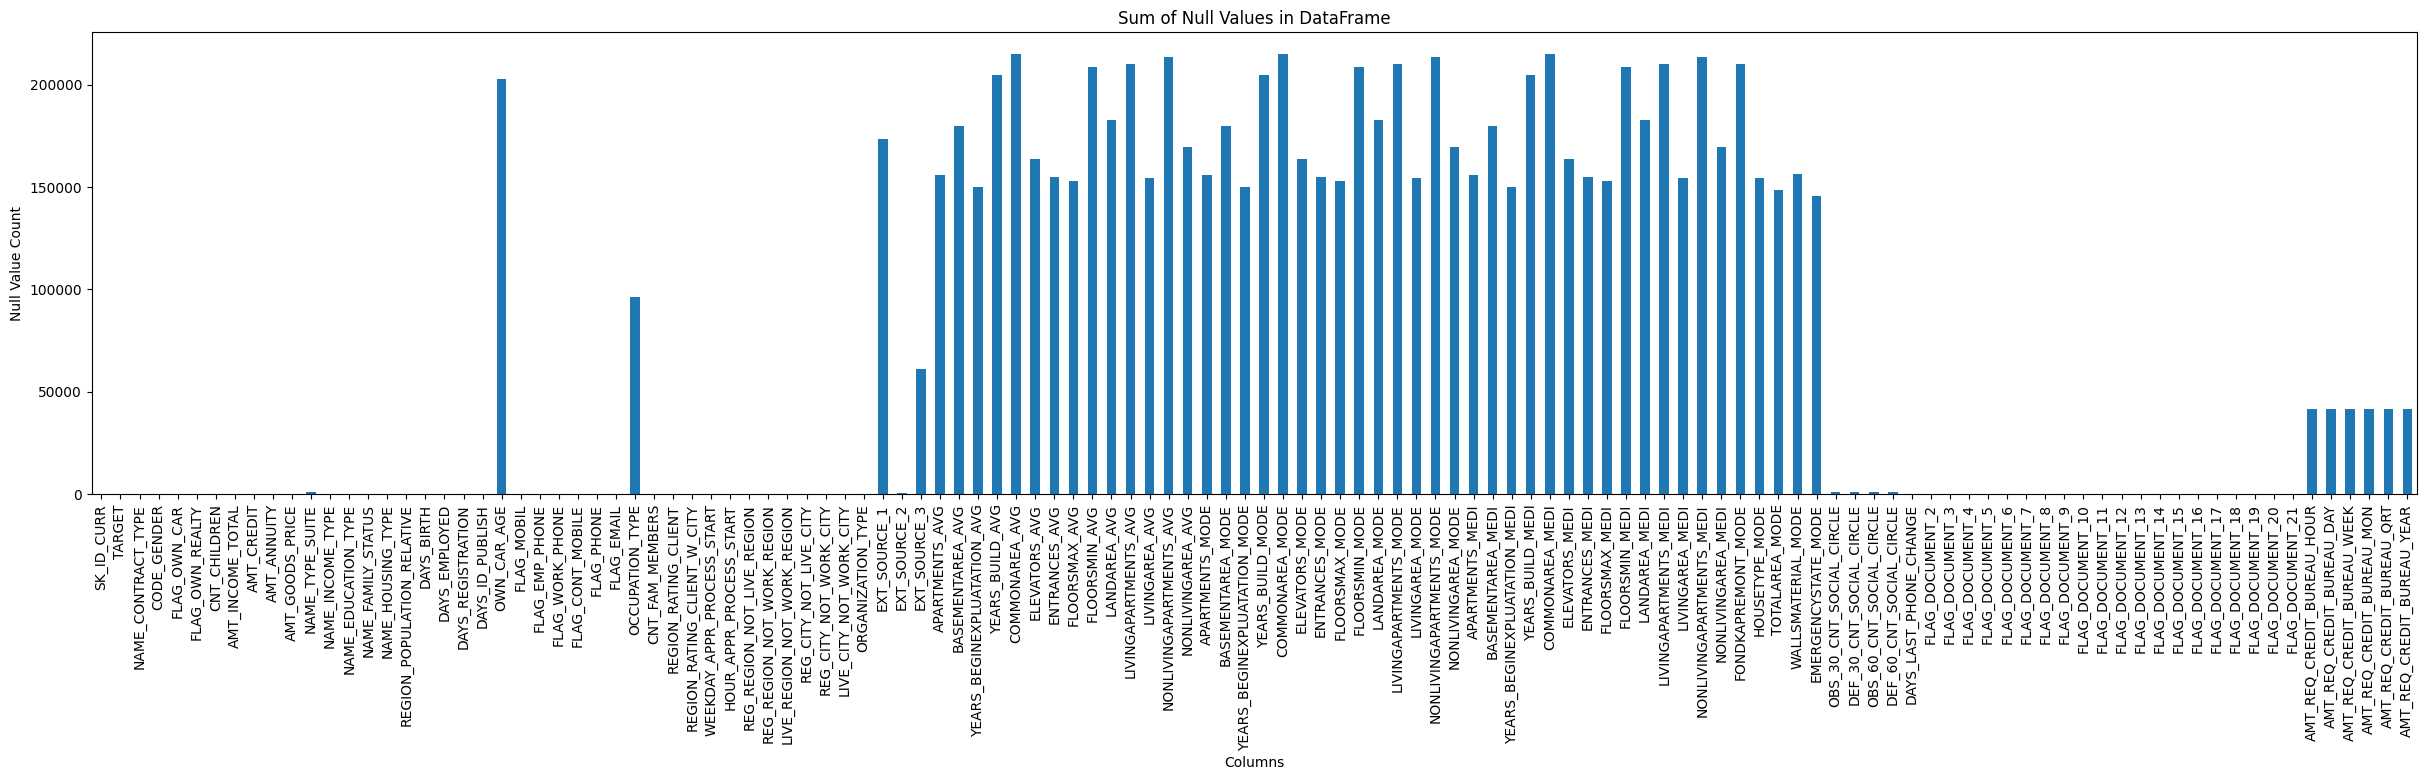

In [ ]:
# Calculate the sum of null values for each column
null_sum = train_df.isnull().sum()

# Increase the figure size
plt.figure(figsize=(30, 6))

# Plot the sum of null values
null_sum.plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Null Value Count')
plt.title('Sum of Null Values in DataFrame')
plt.show()

Something else to consider before looking for the best features is that the classes are imbalanced

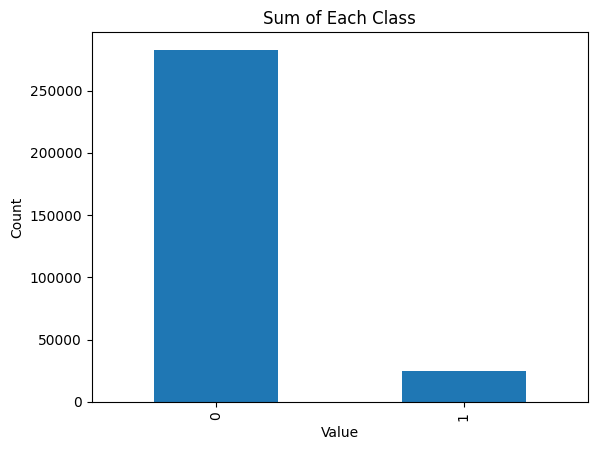

In [ ]:
classes_sum = train_df['TARGET'].value_counts()

classes_sum.plot(kind='bar')
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Sum of Each Class')
plt.show()

In [ ]:
count_class_one = train_df['TARGET'].eq(1).sum()
count_class_one

24825

We will create a new dataset that contains the same amount of classes so we can analyse the features with a correlation matrix

In [ ]:
class_zero = train_df[train_df['TARGET'] == 0].sample(24825)
class_one = train_df[train_df['TARGET'] == 1].sample(24825)

balanced_df = pd.concat([class_zero, class_one])
balanced_df.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
138233      260305       0         Cash loans           F            N   
249694      388910       0         Cash loans           F            Y   
148341      271997       0         Cash loans           F            N   
170254      297322       0         Cash loans           M            Y   
271087      414263       0         Cash loans           M            Y   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
138233               Y             1          112500.0   1724220.0   
249694               Y             0          144000.0    386977.5   
148341               Y             0           85500.0    254700.0   
170254               N             0          135000.0    225000.0   
271087               N             1          247500.0    521280.0   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20  \
138233      50544.0  ...                 0                0                0   
249694      13896.0  ...                 0                0                0   
148341      24808.5  ...                 0                0                0   
170254      15219.0  ...                 0                0                0   
271087      31500.0  ...                 0                0                0   

       FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
138233                0                        0.0                       0.0   
249694                0                        NaN                       NaN   
148341                0                        0.0                       0.0   
170254                0                        0.0                       0.0   
271087                0                        0.0                       0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
138233                         0.0                        0.0   
249694                         NaN                        NaN   
148341                         0.0                        0.0   
170254                         0.0                        0.0   
271087                         0.0                        0.0   

        AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
138233                        1.0                         1.0  
249694                        NaN                         NaN  
148341                        0.0                         1.0  
170254                        0.0                         3.0  
271087                        0.0                         0.0  

[5 rows x 122 columns]

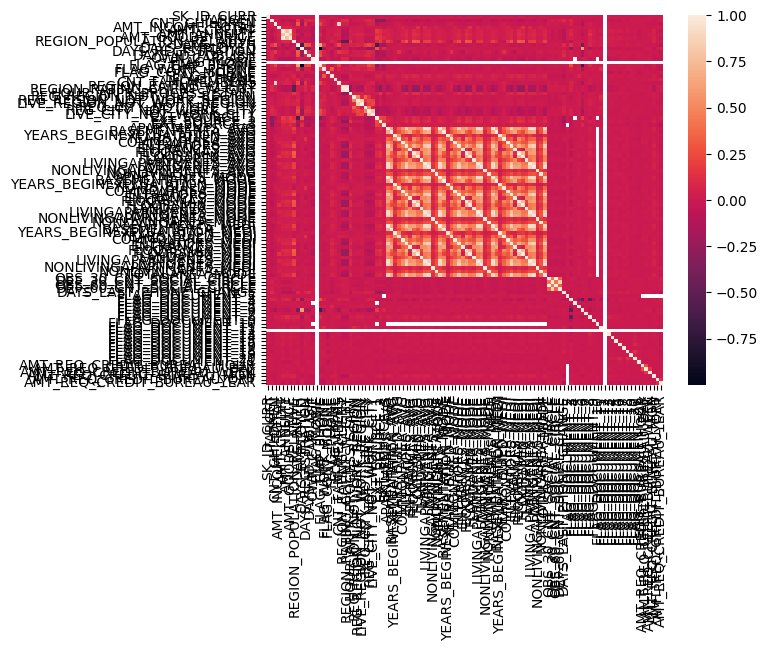

In [ ]:
correlation = balanced_df.corr()

sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels= correlation.columns)

cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '500px'),
                        ('font-size', '12pt')])
]

correlation.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

## EDA

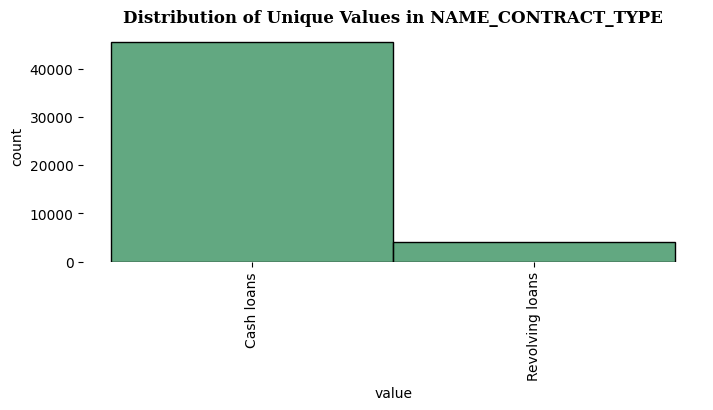

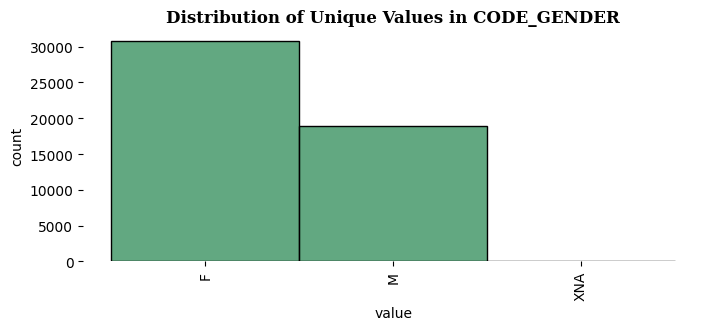

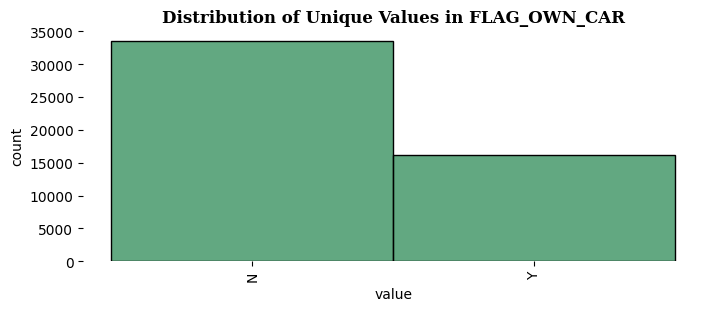

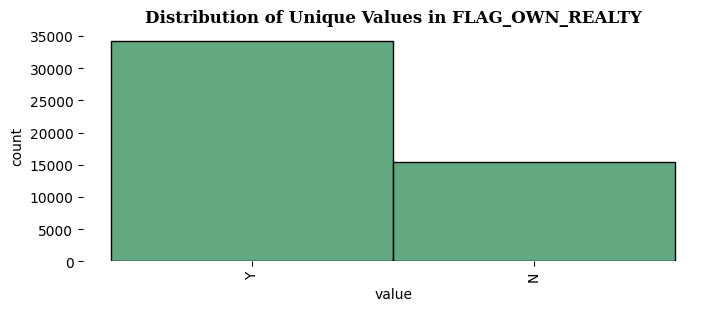

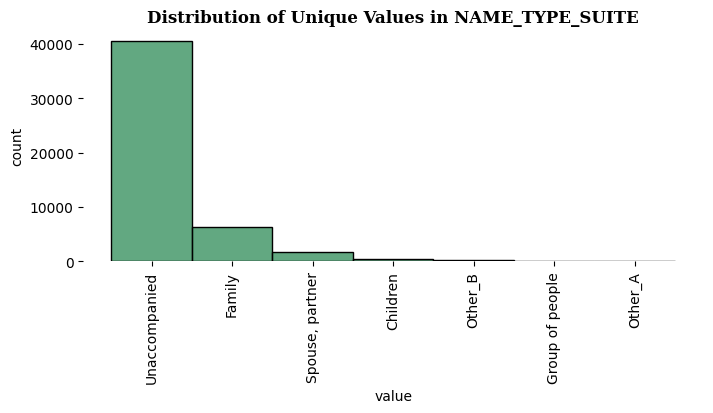

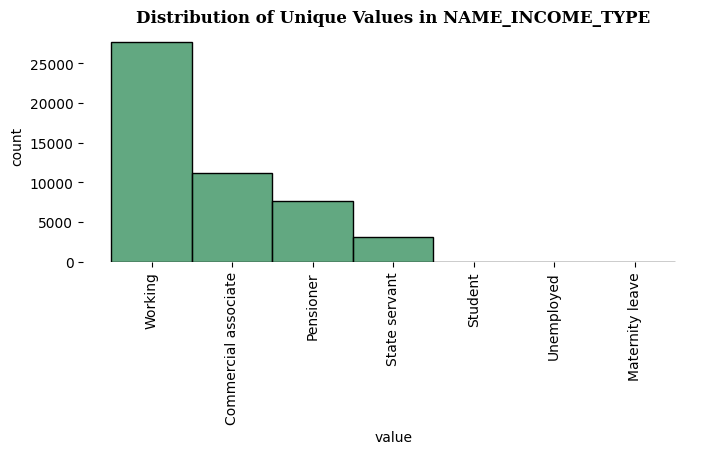

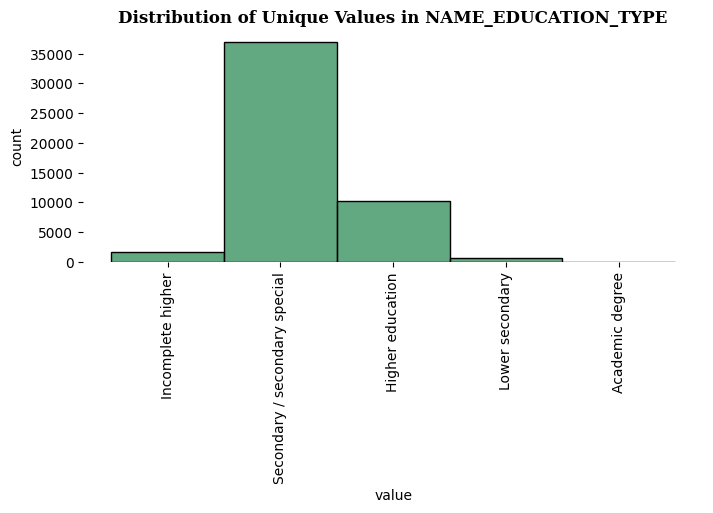

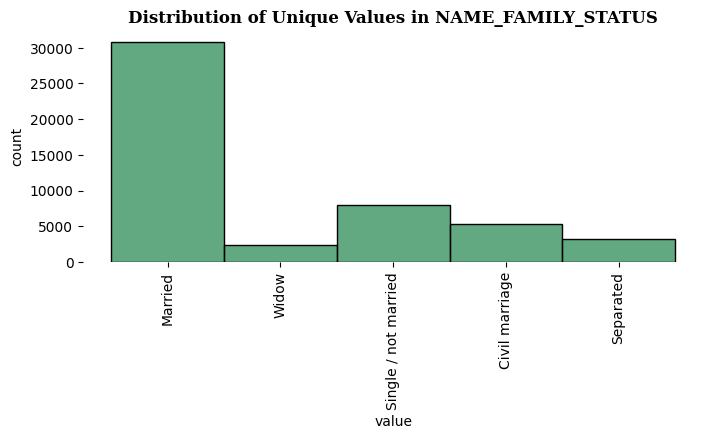

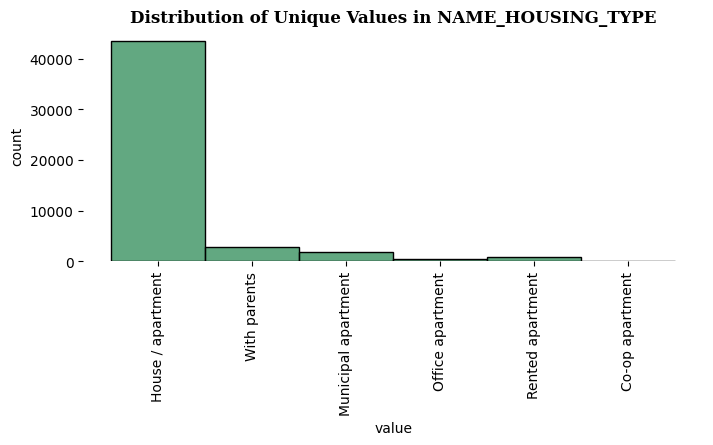

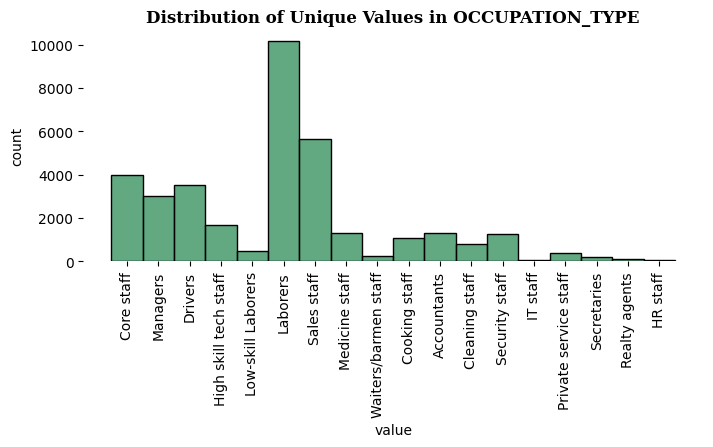

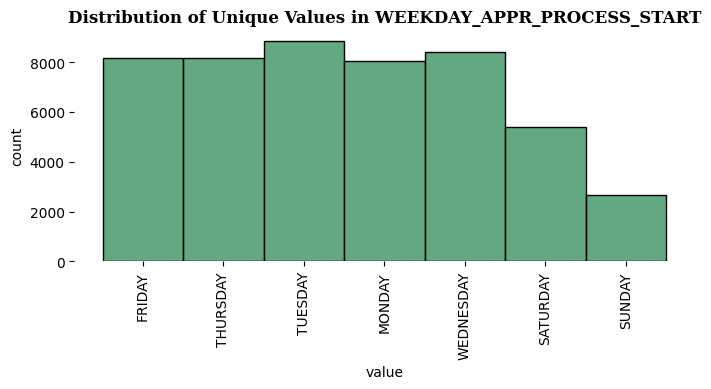

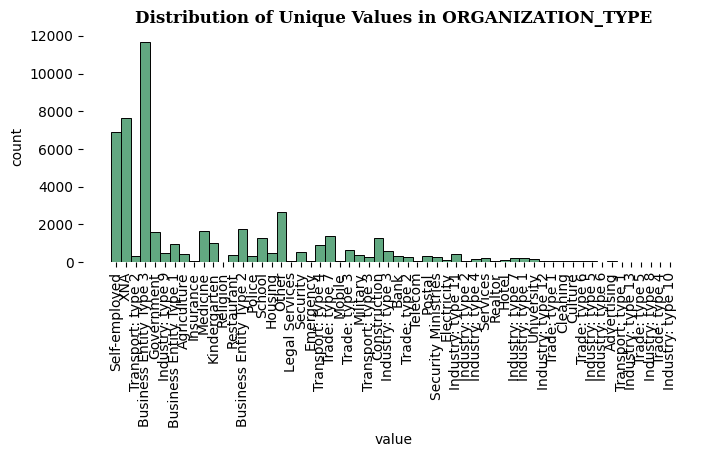

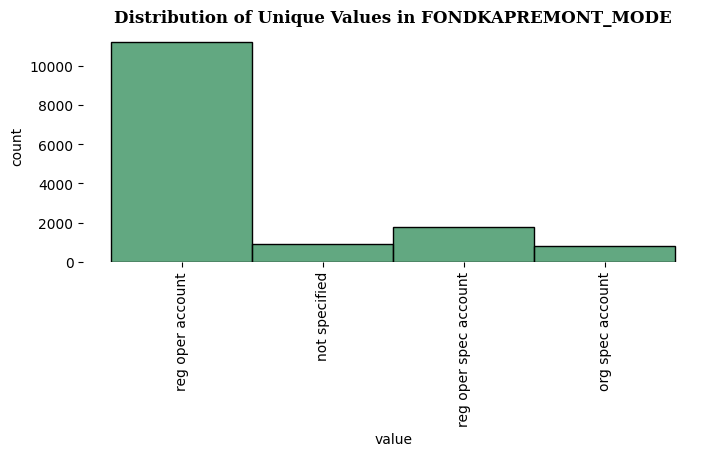

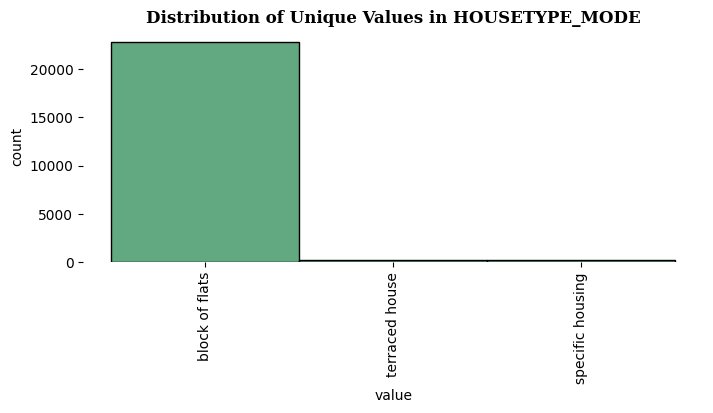

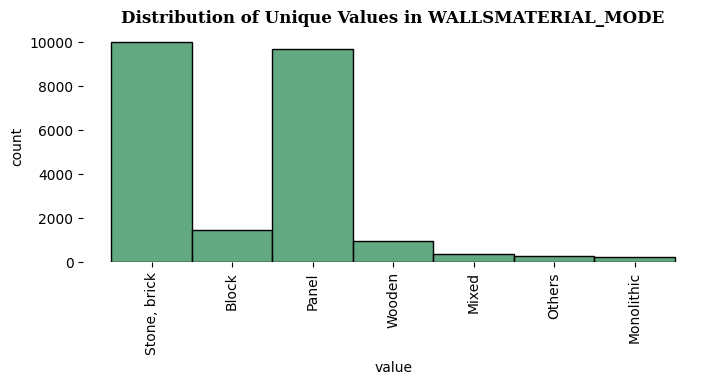

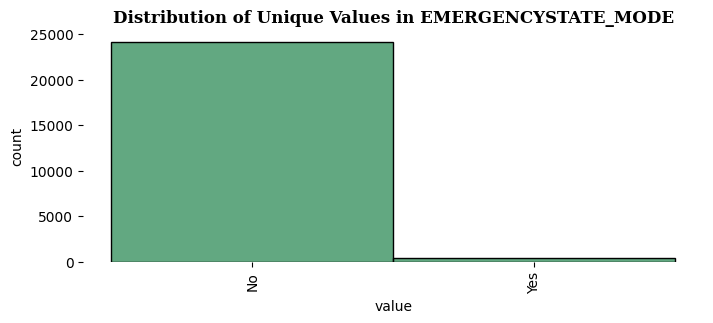

In [ ]:
object_cols = balanced_df.select_dtypes("object").columns

for col in object_cols:
    unique_values = balanced_df[col].dropna().nunique()
    if unique_values < 100:
        fig, ax = plt.subplots(1,1, figsize=(8, 3))
        sns.histplot(balanced_df[col].dropna(), color='seagreen')
        plt.title('Distribution of Unique Values in {}'.format(col), fontweight='bold', fontfamily='serif')
        plt.xlabel('value')
        plt.ylabel('count')
        plt.xticks(rotation='vertical')
        plt.box(False)
        plt.show()


We'll visualize the relation between Target classes and the Features

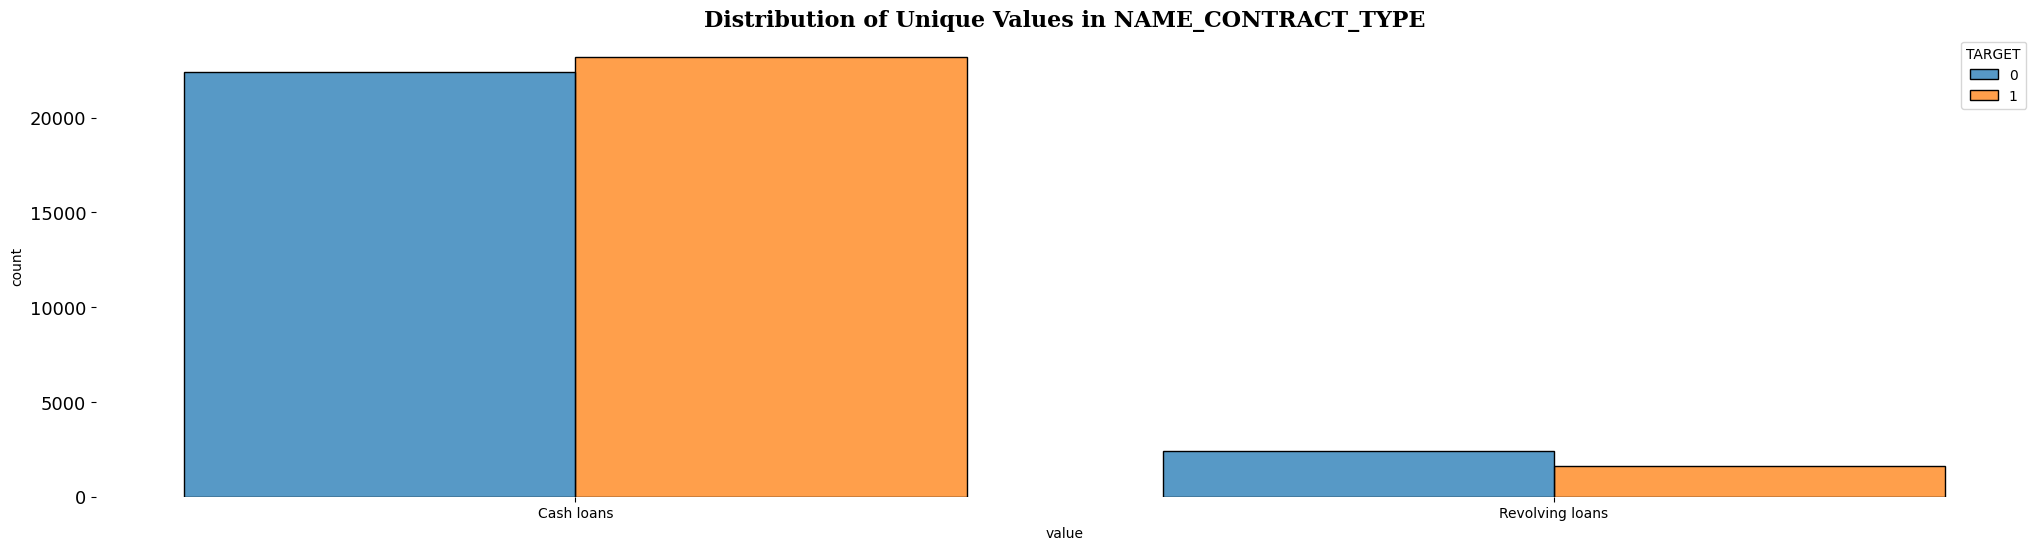

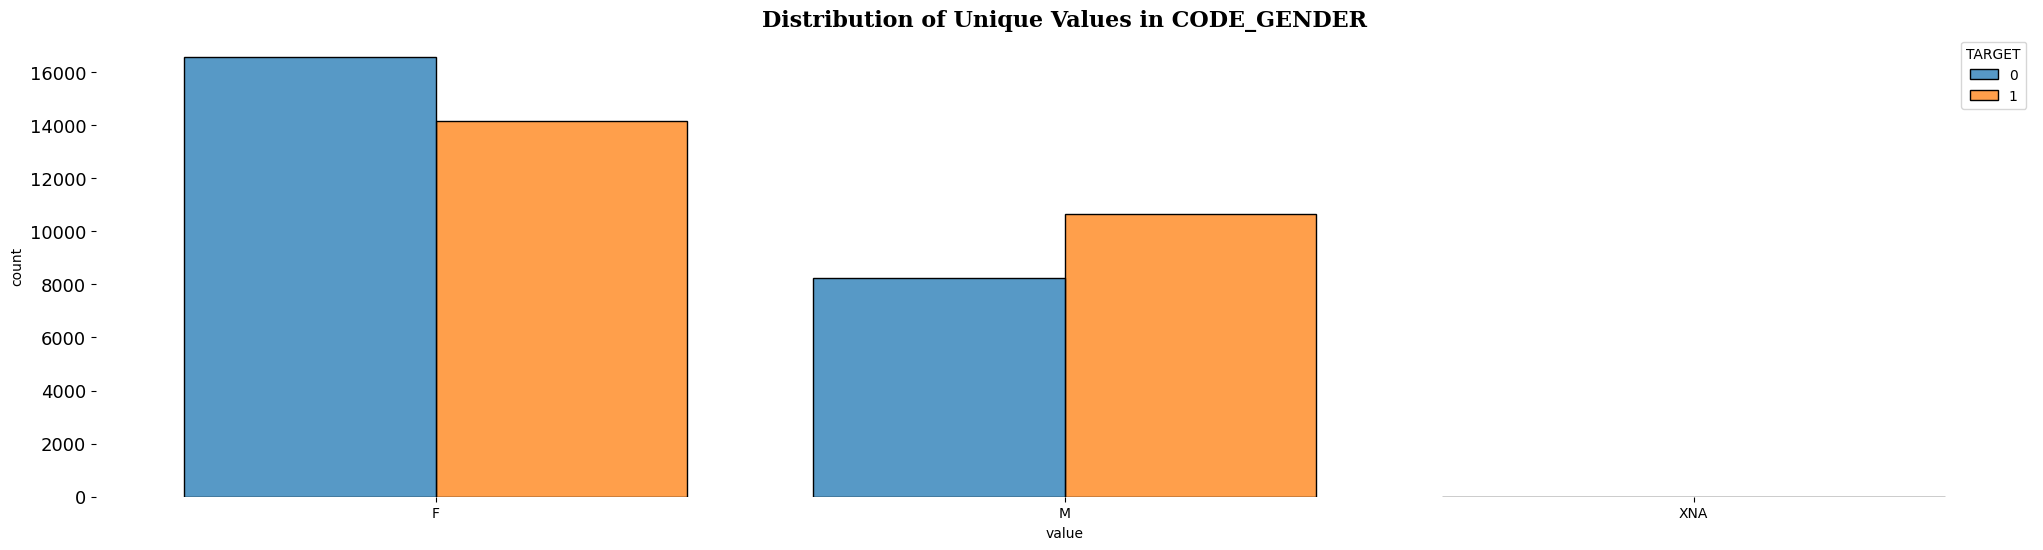

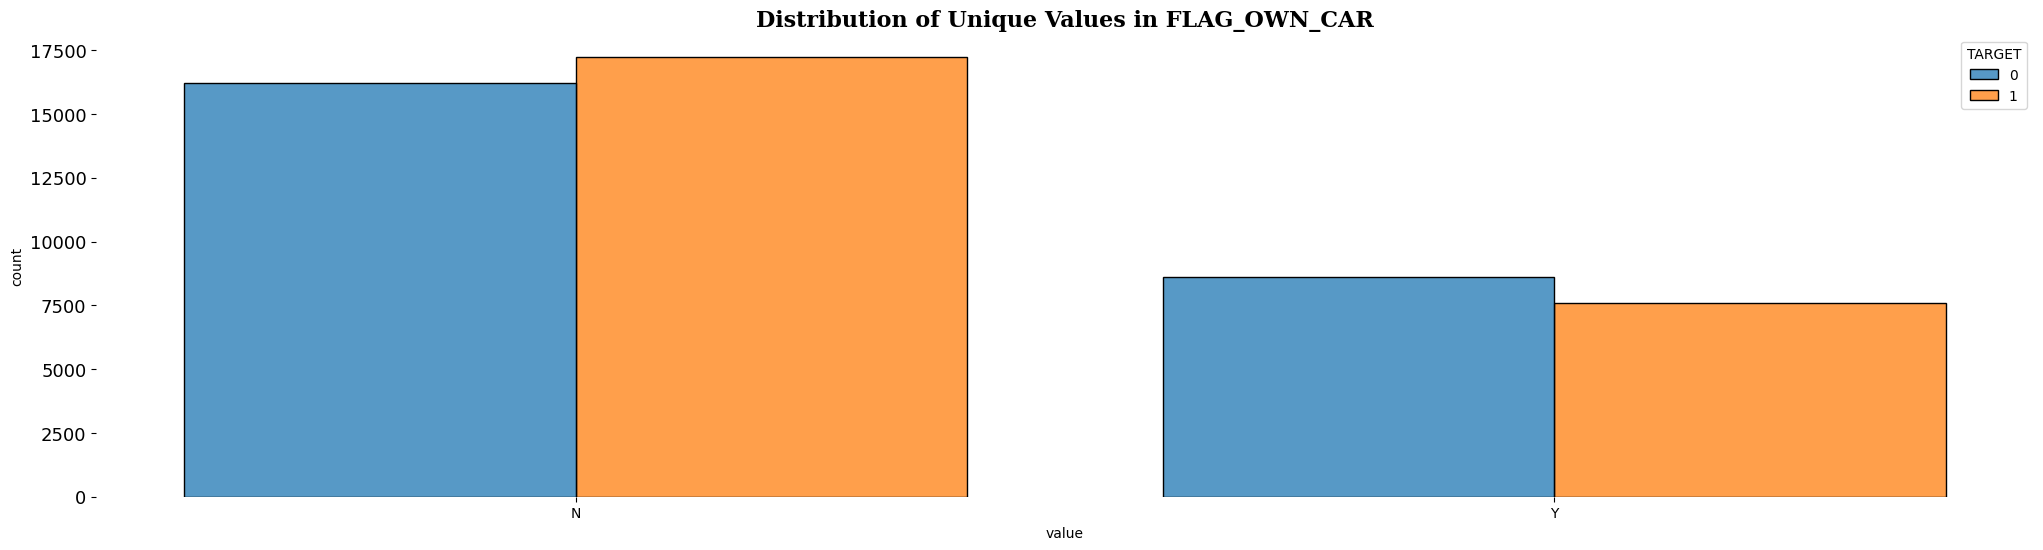

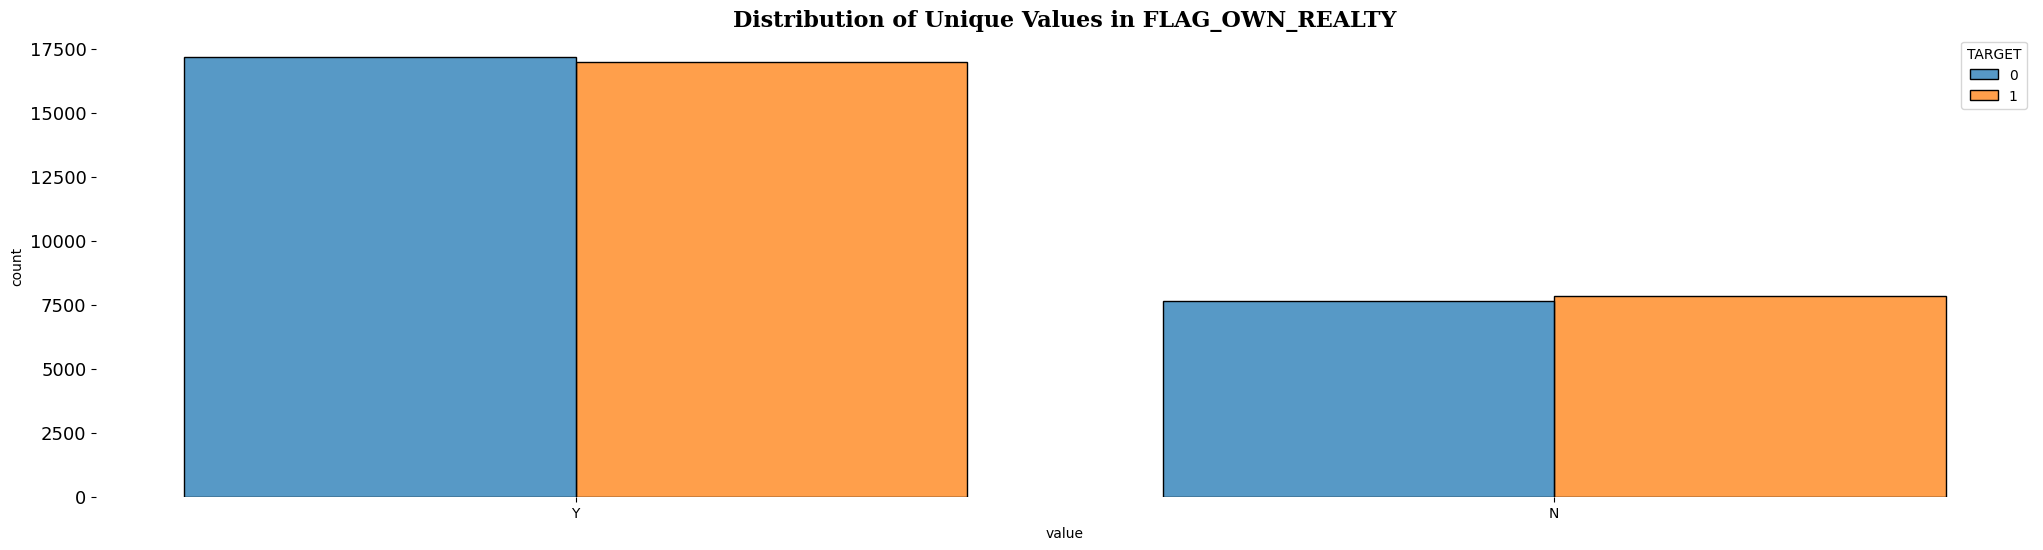

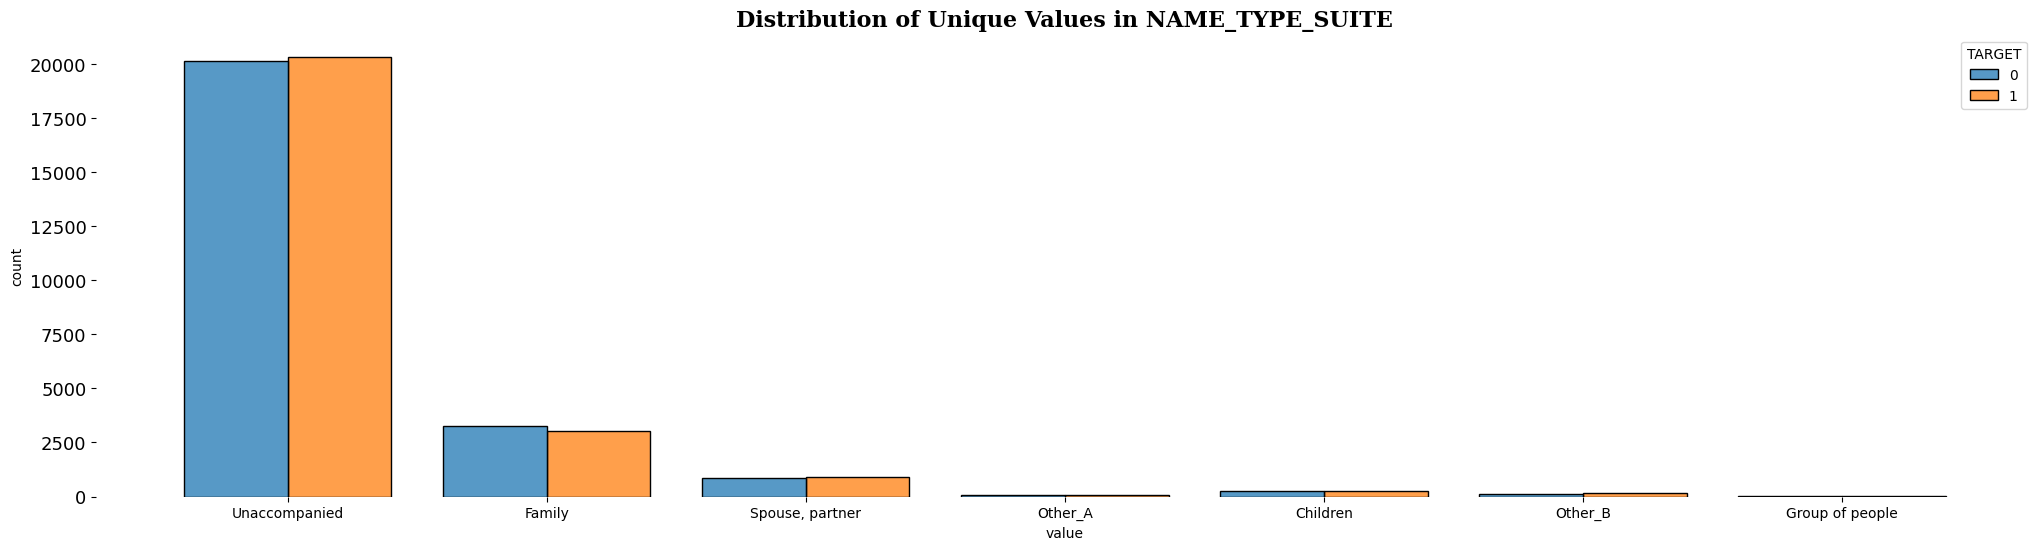

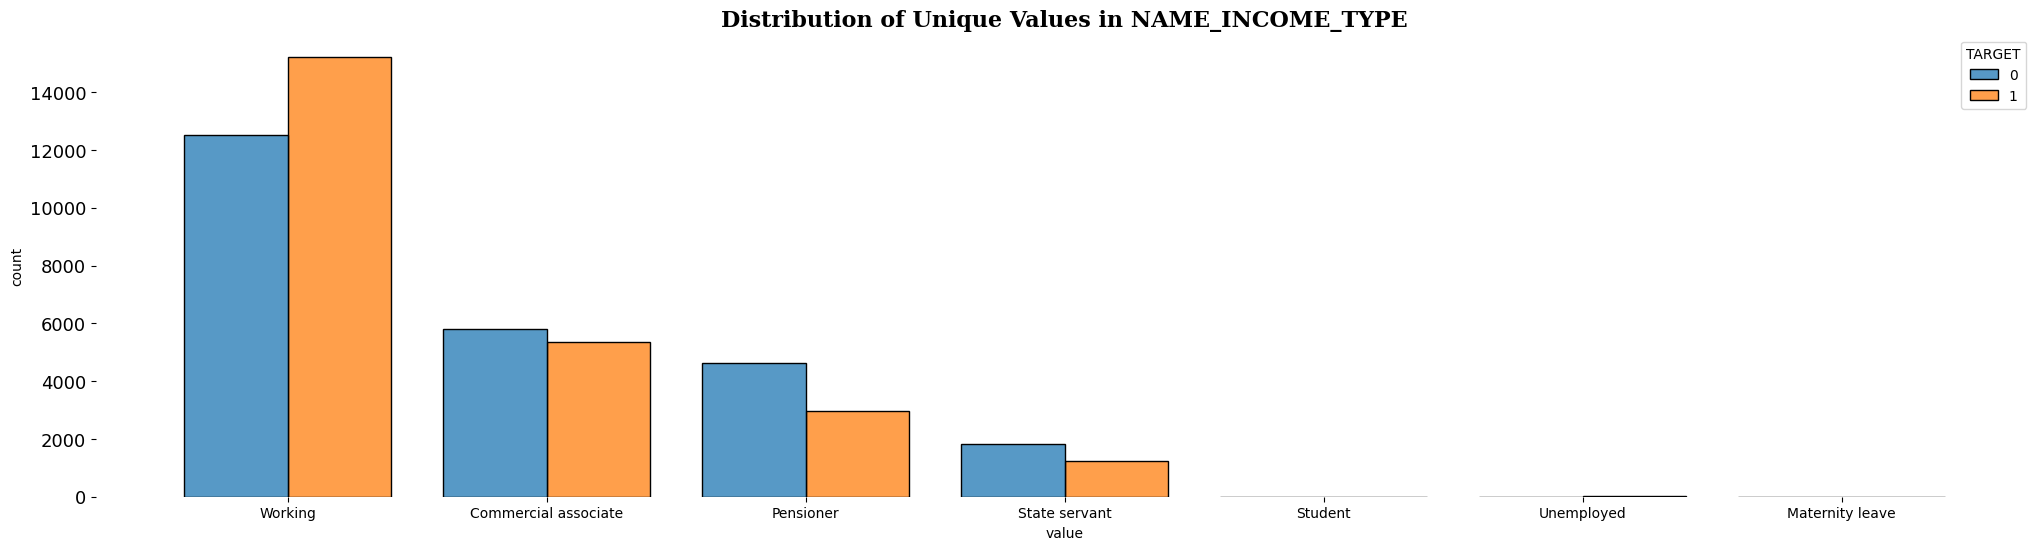

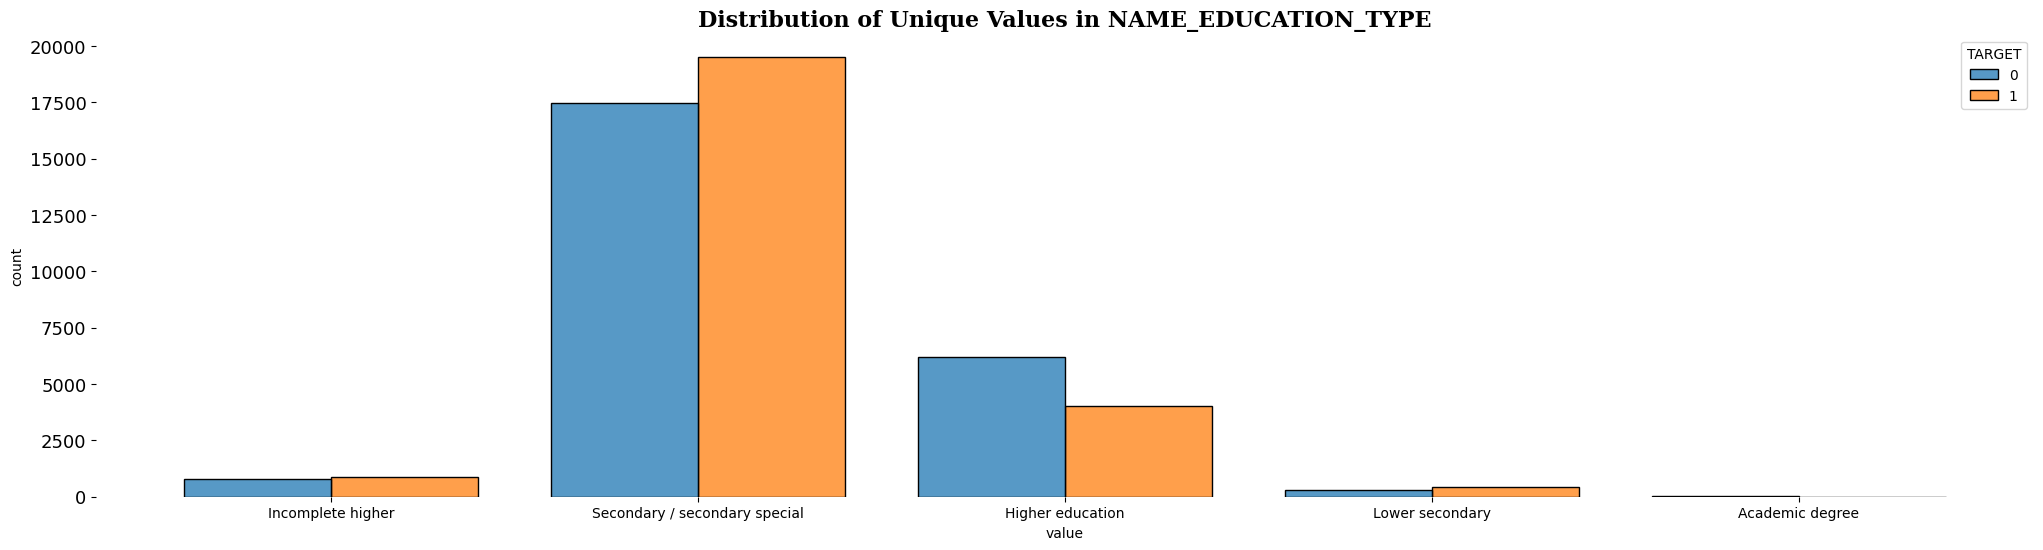

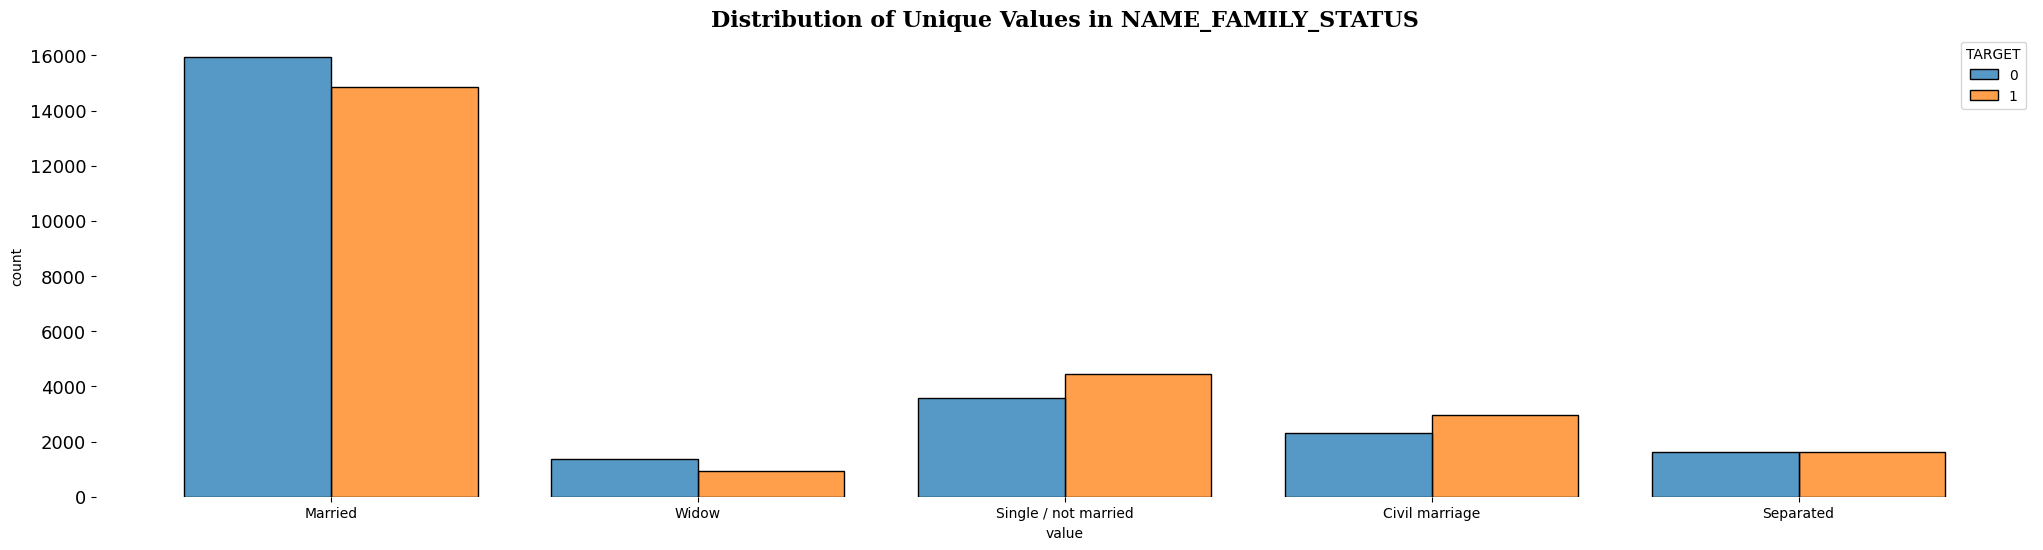

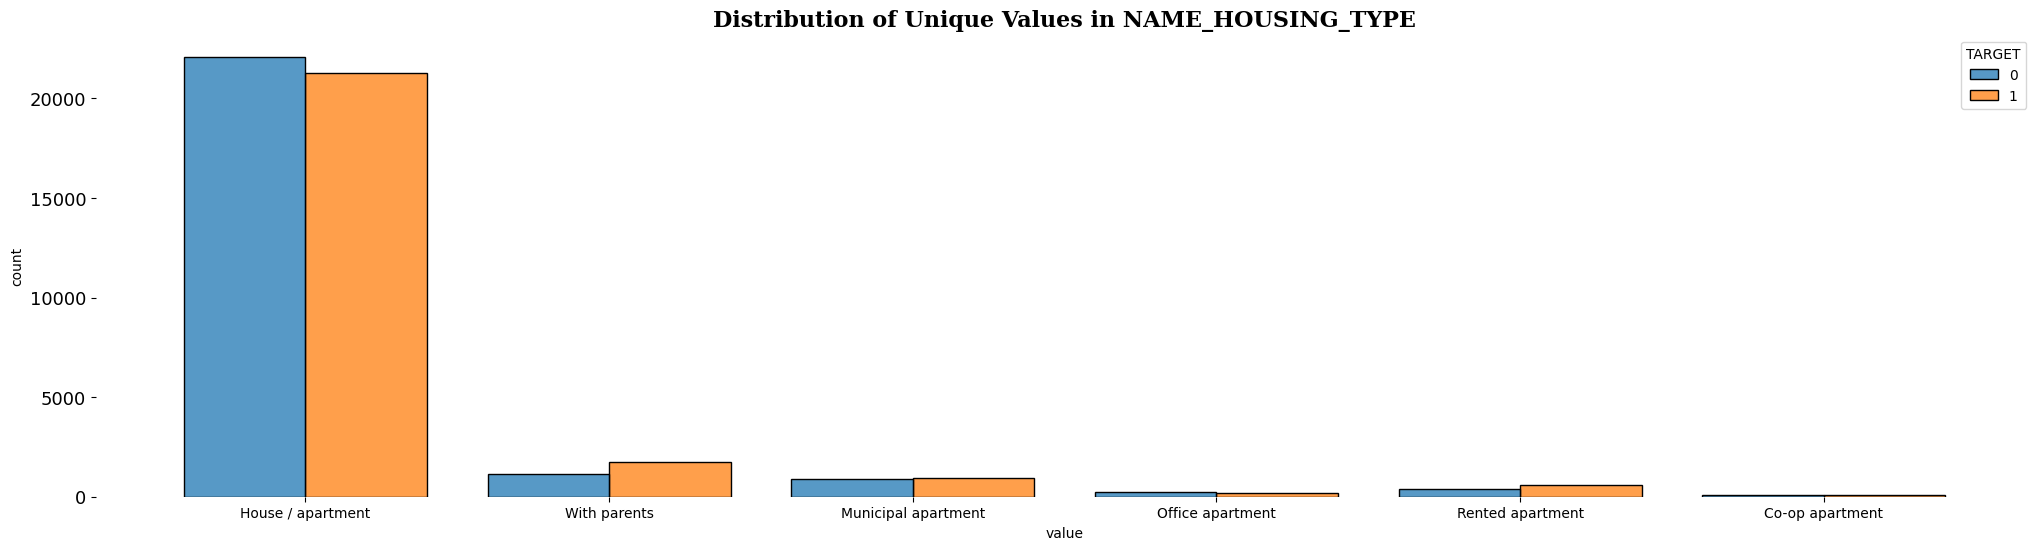

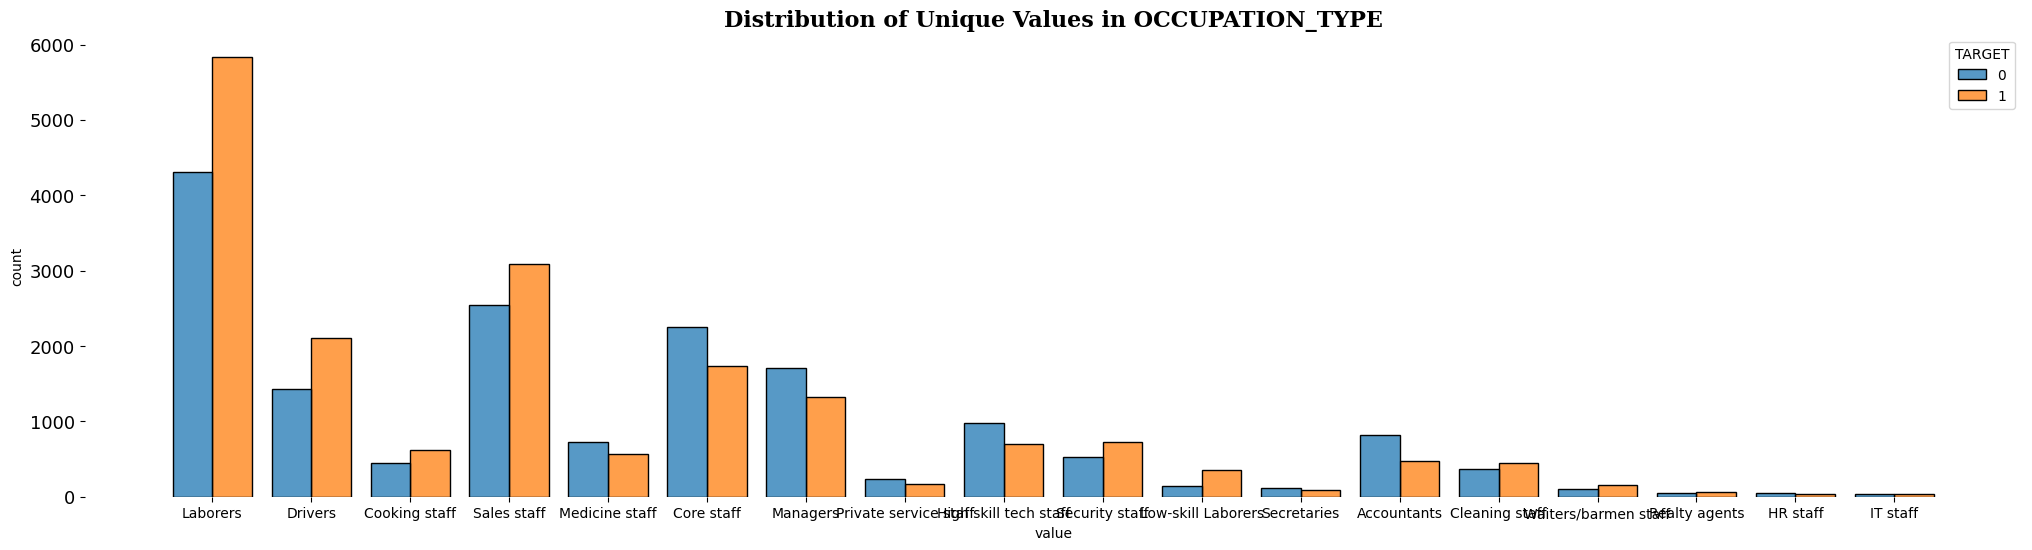

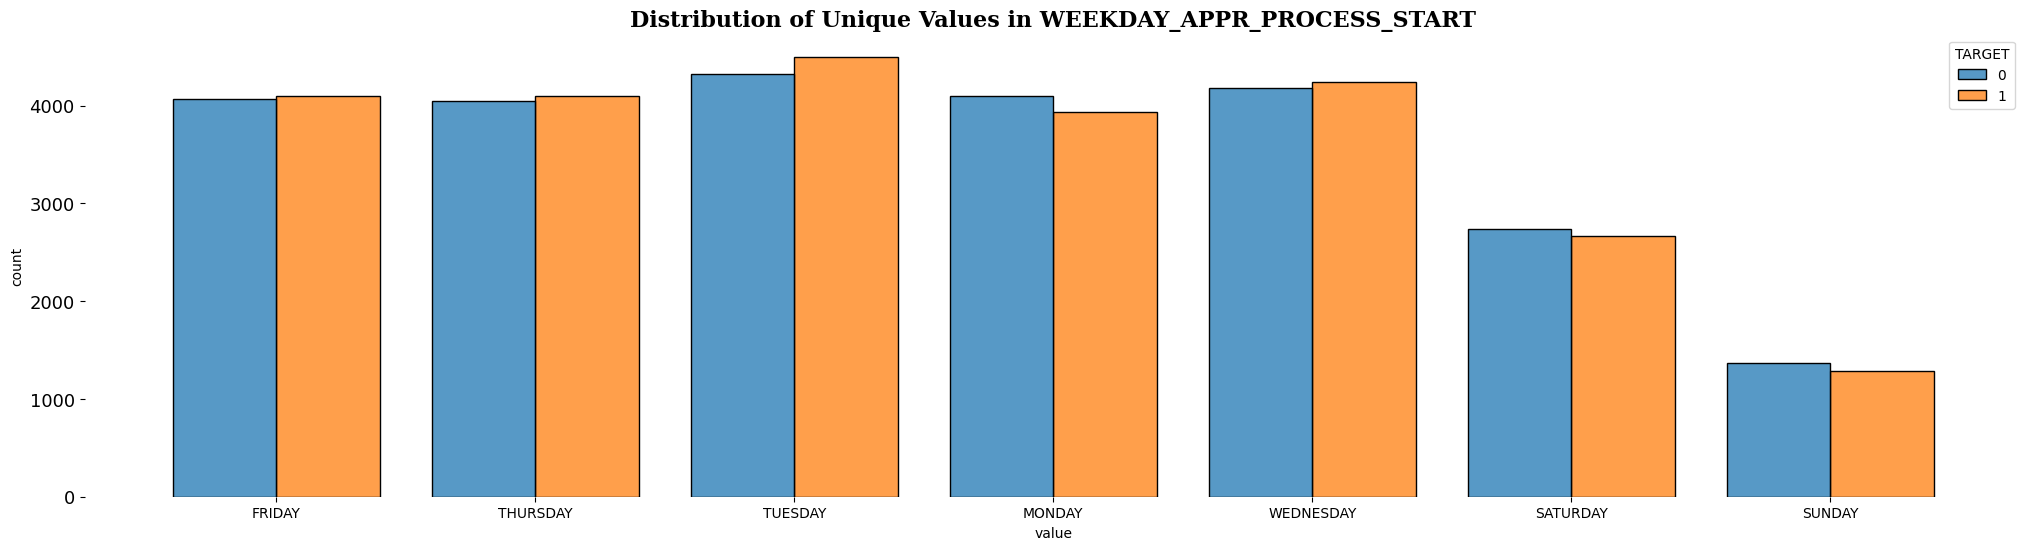

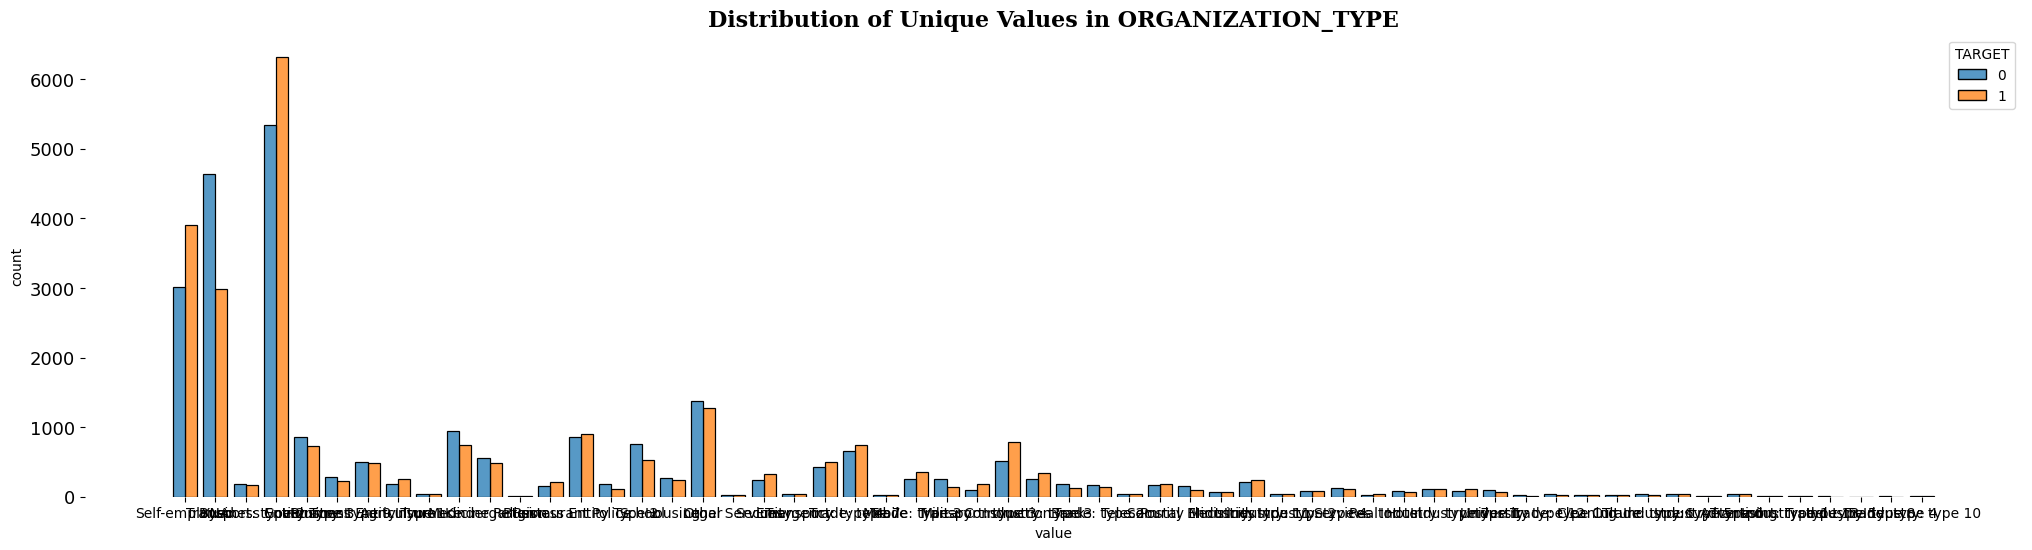

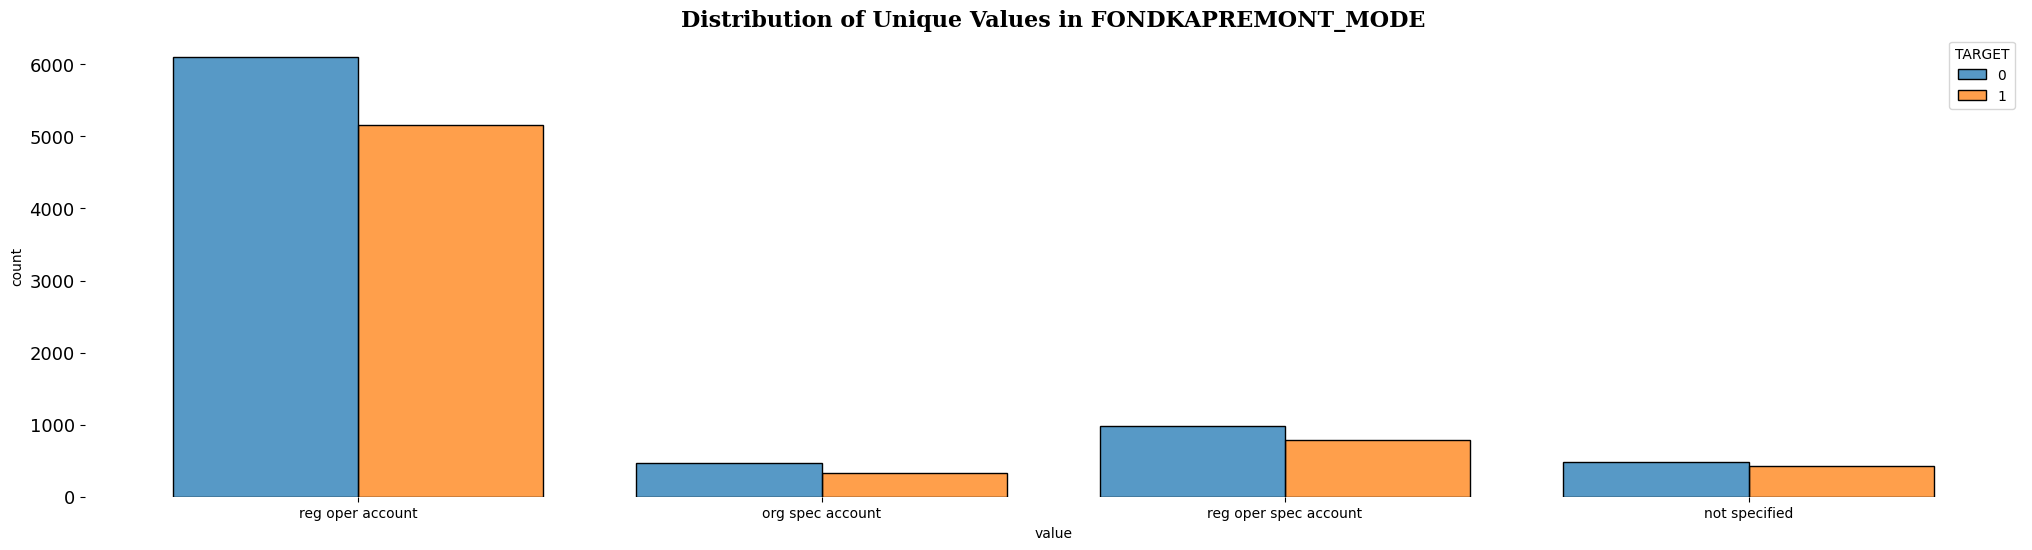

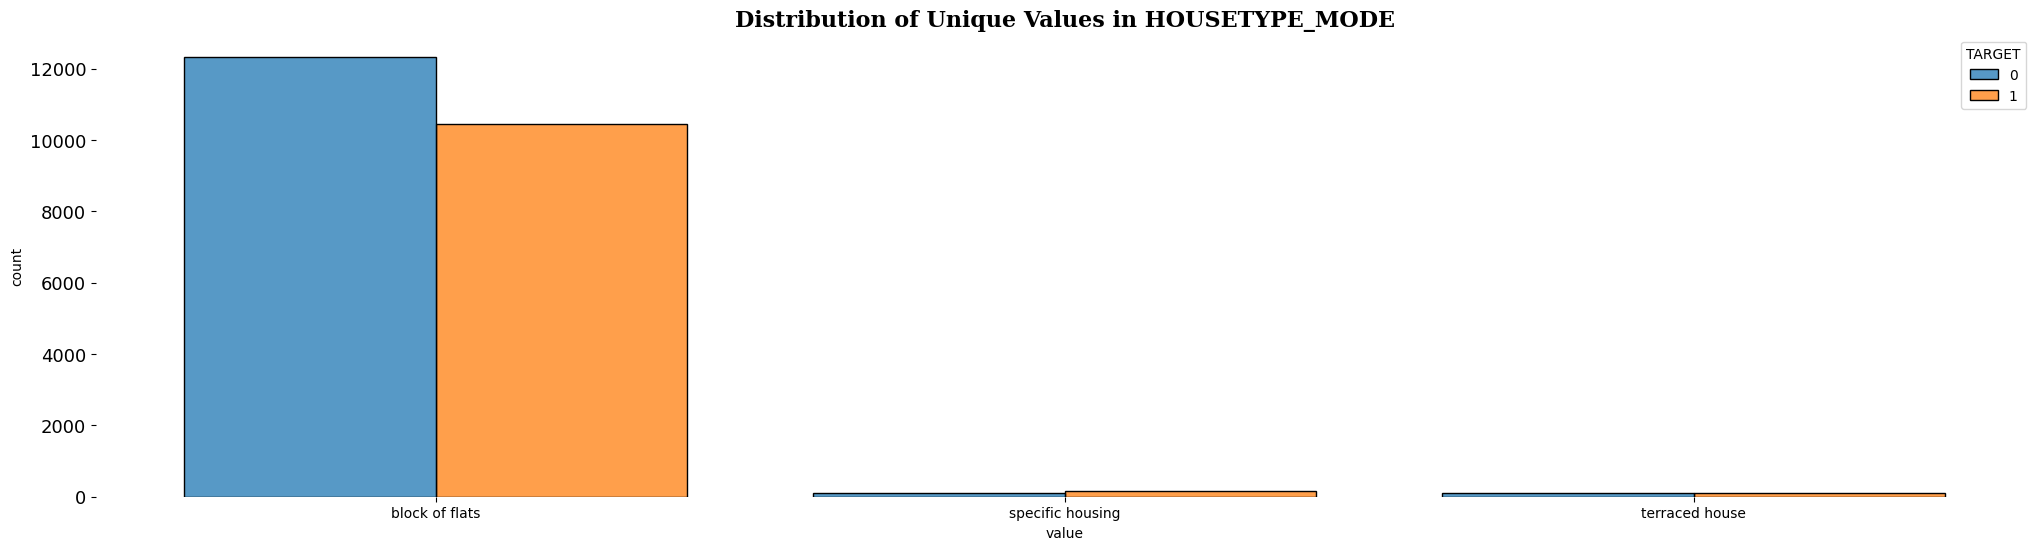

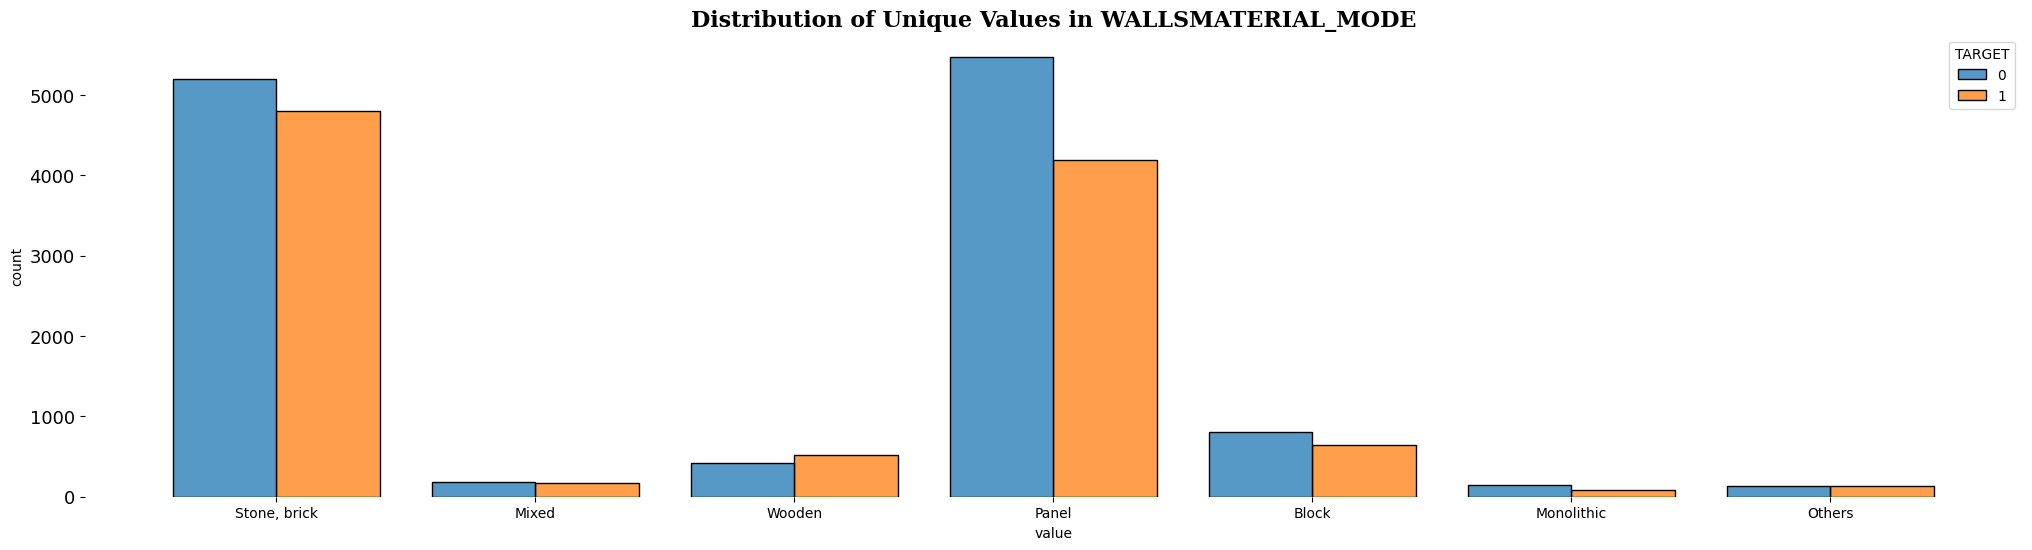

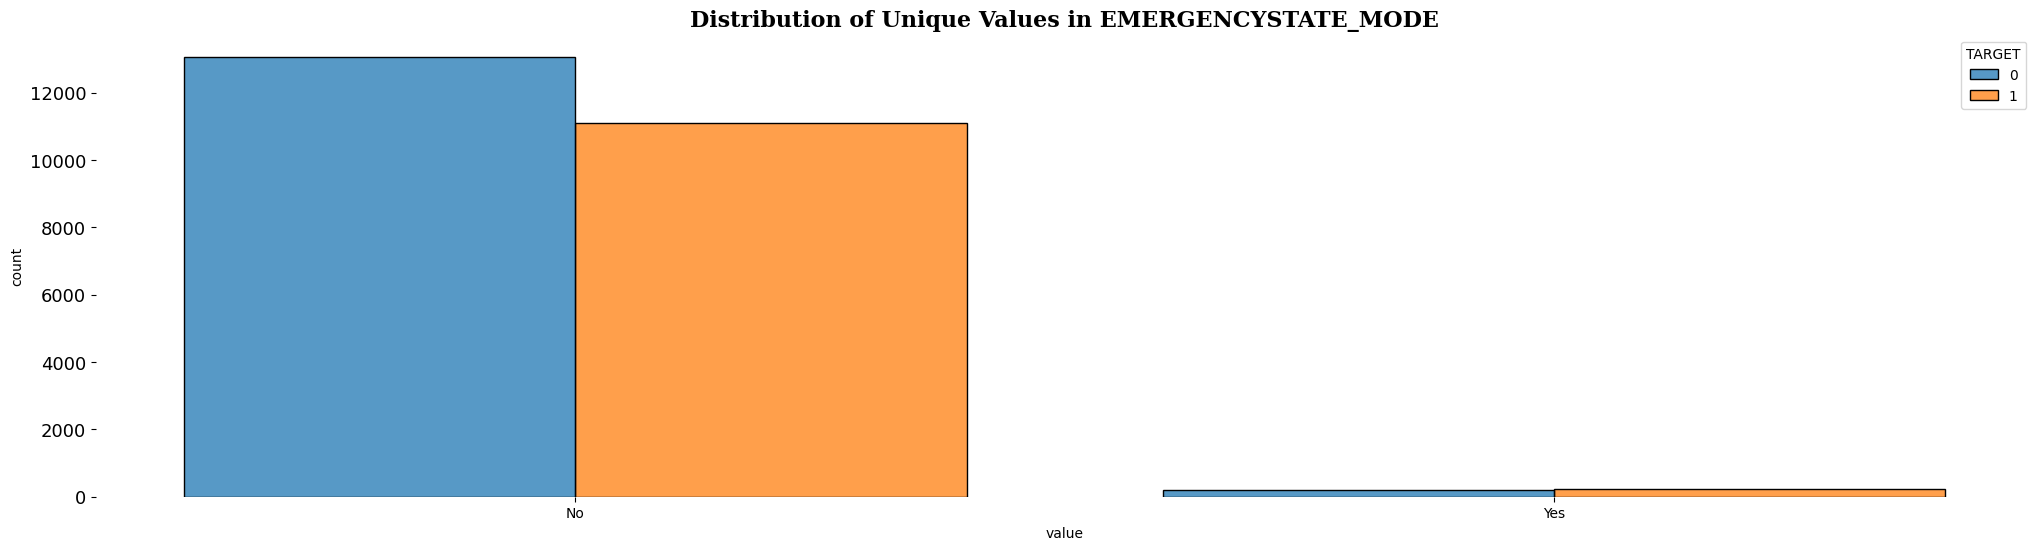

In [ ]:
object_cols = balanced_df.select_dtypes("object").columns

for col in object_cols:
    unique_values = balanced_df[col].dropna().nunique()
    if unique_values < 100:
        fig, ax = plt.subplots(1,1, figsize=(25, 6))
        sns.histplot(x=balanced_df[col].dropna(), hue=balanced_df["TARGET"], multiple="dodge", shrink=.8)
        plt.title('Distribution of Unique Values in {}'.format(col), fontsize=16, fontweight='bold', fontfamily='serif')
        plt.xlabel('value', fontsize=10)
        plt.ylabel('count', fontsize=10)
        plt.yticks(fontsize=13)
        plt.box(False)
        plt.show()


## Feature Selection

In [ ]:
high_correlation =correlation[((correlation > 0.03) | (correlation < -0.03)) & (correlation < 1) ]
high_correlation

SK_ID_CURR    TARGET  CNT_CHILDREN  \
SK_ID_CURR                         NaN       NaN           NaN   
TARGET                             NaN       NaN      0.034633   
CNT_CHILDREN                       NaN  0.034633           NaN   
AMT_INCOME_TOTAL                   NaN       NaN           NaN   
AMT_CREDIT                         NaN -0.063171           NaN   
...                                ...       ...           ...   
AMT_REQ_CREDIT_BUREAU_DAY          NaN       NaN           NaN   
AMT_REQ_CREDIT_BUREAU_WEEK         NaN       NaN           NaN   
AMT_REQ_CREDIT_BUREAU_MON          NaN       NaN           NaN   
AMT_REQ_CREDIT_BUREAU_QRT          NaN       NaN           NaN   
AMT_REQ_CREDIT_BUREAU_YEAR         NaN  0.038922     -0.037576   

                            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                               NaN         NaN          NaN   
TARGET                                   NaN   -0.063171          NaN   
CNT_CHILDREN                             NaN         NaN          NaN   
AMT_INCOME_TOTAL                         NaN    0.061136     0.075864   
AMT_CREDIT                          0.061136         NaN     0.762083   
...                                      ...         ...          ...   
AMT_REQ_CREDIT_BUREAU_DAY                NaN         NaN          NaN   
AMT_REQ_CREDIT_BUREAU_WEEK               NaN         NaN          NaN   
AMT_REQ_CREDIT_BUREAU_MON                NaN    0.060073     0.043415   
AMT_REQ_CREDIT_BUREAU_QRT                NaN         NaN          NaN   
AMT_REQ_CREDIT_BUREAU_YEAR               NaN   -0.039659          NaN   

                            AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
SK_ID_CURR                              NaN                         NaN   
TARGET                            -0.081611                   -0.077817   
CNT_CHILDREN                            NaN                   -0.033518   
AMT_INCOME_TOTAL                   0.061525                         NaN   
AMT_CREDIT                         0.985355                    0.087969   
...                                     ...                         ...   
AMT_REQ_CREDIT_BUREAU_DAY               NaN                         NaN   
AMT_REQ_CREDIT_BUREAU_WEEK              NaN                         NaN   
AMT_REQ_CREDIT_BUREAU_MON          0.062384                    0.070648   
AMT_REQ_CREDIT_BUREAU_QRT               NaN                         NaN   
AMT_REQ_CREDIT_BUREAU_YEAR        -0.042583                         NaN   

                            DAYS_BIRTH  DAYS_EMPLOYED  ...  FLAG_DOCUMENT_18  \
SK_ID_CURR                         NaN            NaN  ...               NaN   
TARGET                        0.143533      -0.089925  ...               NaN   
CNT_CHILDREN                  0.296404      -0.218141  ...               NaN   
AMT_INCOME_TOTAL                   NaN            NaN  ...               NaN   
AMT_CREDIT                   -0.097732      -0.033355  ...          0.033200   
...                                ...            ...  ...               ...   
AMT_REQ_CREDIT_BUREAU_DAY          NaN            NaN  ...               NaN   
AMT_REQ_CREDIT_BUREAU_WEEK         NaN            NaN  ...               NaN   
AMT_REQ_CREDIT_BUREAU_MON          NaN      -0.033418  ...               NaN   
AMT_REQ_CREDIT_BUREAU_QRT          NaN            NaN  ...               NaN   
AMT_REQ_CREDIT_BUREAU_YEAR   -0.071003       0.046138  ...         -0.050753   

                            FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  \
SK_ID_CURR                               NaN               NaN   
TARGET                                   NaN               NaN   
CNT_CHILDREN                             NaN               NaN   
AMT_INCOME_TOTAL                         NaN               NaN   
AMT_CREDIT                               NaN               NaN   
...                                      ...               ...   
AMT_REQ_CREDIT_BUREAU_DAY         

In [ ]:
# For each feature, list its correlated feature
correlated_columns = {}
for col in high_correlation.columns:
    correlated_features = high_correlation.columns[(~high_correlation[col].isna())].tolist()
    correlated_features = list(set(correlated_features).difference(set(correlated_columns.keys())))
    correlated_columns[col] = correlated_features

In [ ]:
# From correlated features with TARGET, select their top 3 correlated features
selected_features = correlated_columns["TARGET"]
for feature in selected_features.copy():
    correlated_correlated_features = high_correlation[feature].abs().sort_values(ascending=False)
    features_to_select = correlated_correlated_features[correlated_correlated_features < 90][:3].index.tolist()
    selected_features.extend(features_to_select)

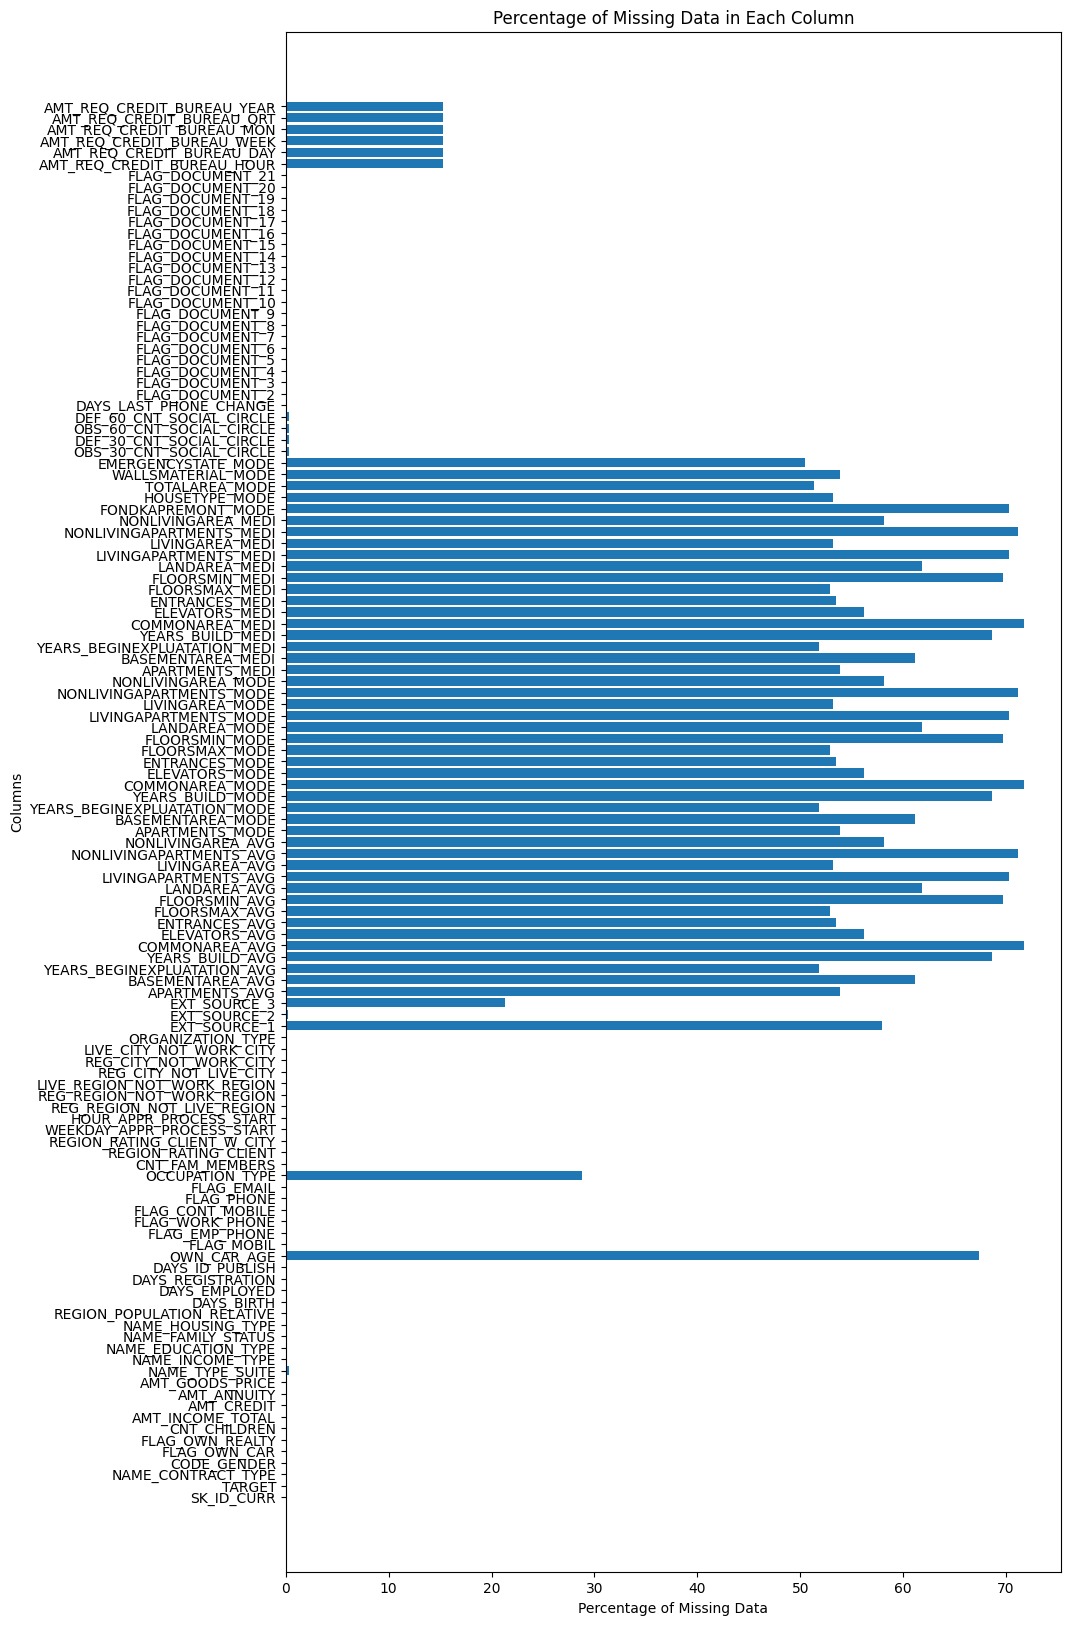

In [ ]:
whole = len(balanced_df)
missing_percentages = []

for col in balanced_df.columns:
    part = balanced_df[col].isna().sum()
    percentage = (part / whole) * 100
    missing_percentages.append(percentage)


plt.figure(figsize=(10, 20))
plt.barh(balanced_df.columns, missing_percentages)  # Use barh() for horizontal bar plot
plt.xlabel('Percentage of Missing Data')
plt.ylabel('Columns')
plt.title('Percentage of Missing Data in Each Column')
plt.show()

Considering the previous analisys is better to drop the columns with high volume of missing data

In [ ]:
# Fill EXT_SOURCE_1 given EXT_SOURCE_2 and EXT_SOURCE_3

data = balanced_df.loc[:, ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].dropna()
x_filler = data.drop(columns="EXT_SOURCE_1")
y_filler = data["EXT_SOURCE_1"]

reg_model = Ridge(alpha=0.001)
reg_model.fit(x_filler, y_filler)

mask = (~(balanced_df["EXT_SOURCE_2"].isna())) & (~(balanced_df["EXT_SOURCE_3"].isna())) & (balanced_df["EXT_SOURCE_1"].isna())
x_pred = balanced_df.loc[mask,["EXT_SOURCE_2", "EXT_SOURCE_3"]]
balanced_df.loc[mask,"EXT_SOURCE_1"] = reg_model.predict(x_pred)

In [ ]:
# Fill EXT_SOURCE_3 given EXT_SOURCE_2 and EXT_SOURCE_1

data = balanced_df.loc[:, ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].dropna()
x_filler = data.drop(columns="EXT_SOURCE_3")
y_filler = data["EXT_SOURCE_3"]

reg_model = Ridge(alpha=0.001)
reg_model.fit(x_filler, y_filler)

mask = (~(balanced_df["EXT_SOURCE_2"].isna())) & (~(balanced_df["EXT_SOURCE_1"].isna())) & (balanced_df["EXT_SOURCE_3"].isna())
x_pred = balanced_df.loc[mask,["EXT_SOURCE_1", "EXT_SOURCE_2"]]
balanced_df.loc[mask,"EXT_SOURCE_3"] = reg_model.predict(x_pred)

In [ ]:
# Fill remaining missings using median
balanced_df["EXT_SOURCE_1"] = balanced_df["EXT_SOURCE_1"].fillna(balanced_df["EXT_SOURCE_1"].median())
balanced_df["EXT_SOURCE_2"] = balanced_df["EXT_SOURCE_2"].fillna(balanced_df["EXT_SOURCE_2"].median())
balanced_df["EXT_SOURCE_3"] = balanced_df["EXT_SOURCE_3"].fillna(balanced_df["EXT_SOURCE_3"].median())
balanced_df["DAYS_LAST_PHONE_CHANGE"] = balanced_df["DAYS_LAST_PHONE_CHANGE"].fillna(balanced_df["DAYS_LAST_PHONE_CHANGE"].median())

# Fill remaining missings using mean
balanced_df["AMT_ANNUITY"] = balanced_df["AMT_ANNUITY"].fillna(balanced_df["AMT_ANNUITY"].mean())
balanced_df["AMT_GOODS_PRICE"] = balanced_df["AMT_GOODS_PRICE"].fillna(balanced_df["AMT_GOODS_PRICE"].mean())
balanced_df["AMT_REQ_CREDIT_BUREAU_YEAR"] = balanced_df["AMT_REQ_CREDIT_BUREAU_YEAR"].fillna(balanced_df["AMT_REQ_CREDIT_BUREAU_YEAR"].mean())


In [ ]:
X = balanced_df.drop(columns=["TARGET"]).copy()
y = balanced_df['TARGET']

In [ ]:
# Large portion of missing values -> better to drop column
X = X.drop(columns=["SK_ID_CURR",
    "FLOORSMIN_MODE",
    "FLOORSMIN_MEDI",
    "FLOORSMIN_AVG",
    "FLOORSMAX_MODE",
    "FLOORSMAX_MEDI",
    "FLOORSMAX_AVG",
    'APARTMENTS_MODE',
    'DEF_30_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE',
    'ELEVATORS_AVG',
    'ELEVATORS_MEDI',
    'ELEVATORS_MODE',
    'FLOORSMAX_AVG',
    'FLOORSMAX_MEDI',
    'FLOORSMAX_MODE',
    'FLOORSMIN_AVG',
    'FLOORSMIN_MEDI',
    'FLOORSMIN_MODE',
    'LIVINGAREA_AVG',
    'LIVINGAREA_MEDI',
    'LIVINGAREA_MODE',
    'OBS_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE',
    'OWN_CAR_AGE',
    'TOTALAREA_MODE',
    'FLAG_DOCUMENT_2',
    'FLAG_DOCUMENT_3',
    'FLAG_DOCUMENT_4',
    'FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6',
    'FLAG_DOCUMENT_7',
    'FLAG_DOCUMENT_8',
    'FLAG_DOCUMENT_9',
    'FLAG_DOCUMENT_10',
    'FLAG_DOCUMENT_11',
    'FLAG_DOCUMENT_12',
    'FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14',
    'FLAG_DOCUMENT_15',
    'FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_17',
    'FLAG_DOCUMENT_18',
    'FLAG_DOCUMENT_19',
    'FLAG_DOCUMENT_20',
    'FLAG_DOCUMENT_21',
    'APARTMENTS_AVG',
    'BASEMENTAREA_AVG',
    'YEARS_BEGINEXPLUATATION_AVG',
    'YEARS_BUILD_AVG',
    'COMMONAREA_AVG',
    'ENTRANCES_AVG',
    'LANDAREA_AVG',
    'LIVINGAPARTMENTS_AVG',
    'NONLIVINGAPARTMENTS_AVG',
    'NONLIVINGAREA_AVG',
    'BASEMENTAREA_MODE',
    'YEARS_BEGINEXPLUATATION_MODE',
    'YEARS_BUILD_MODE',
    'COMMONAREA_MODE',
    'ENTRANCES_MODE',
    'LANDAREA_MODE',
    'LIVINGAPARTMENTS_MODE',
    'NONLIVINGAPARTMENTS_MODE',
    'NONLIVINGAREA_MODE',
    'APARTMENTS_MEDI',
    'BASEMENTAREA_MEDI',
    'YEARS_BEGINEXPLUATATION_MEDI',
    'YEARS_BUILD_MEDI',
    'COMMONAREA_MEDI',
    'ENTRANCES_MEDI',
    'LANDAREA_MEDI',
    'LIVINGAPARTMENTS_MEDI',
    'NONLIVINGAPARTMENTS_MEDI',
    'NONLIVINGAREA_MEDI'])

In [ ]:
X.head()
X.to_csv('bla.csv')

We have features that will require One Hot Encoding, Scaling or Ordinal Encoding.

In [4]:
FEATURES_TO_OHE = ['NAME_CONTRACT_TYPE',
                   'CODE_GENDER',
                   'NAME_TYPE_SUITE',
                   'NAME_INCOME_TYPE',
                   'NAME_EDUCATION_TYPE',
                   'NAME_FAMILY_STATUS',
                   'NAME_HOUSING_TYPE',
                   'OCCUPATION_TYPE',
                   'ORGANIZATION_TYPE',
                   'FONDKAPREMONT_MODE',
                   'HOUSETYPE_MODE',
                   'WALLSMATERIAL_MODE']

FEATURES_TO_SCALE = ['CNT_CHILDREN',
                    'AMT_INCOME_TOTAL',
                    'AMT_CREDIT',
                    'AMT_ANNUITY',
                    'AMT_GOODS_PRICE',
                    'REGION_POPULATION_RELATIVE',
                    'DAYS_BIRTH',
                    'DAYS_EMPLOYED',
                    'DAYS_REGISTRATION',
                    'DAYS_ID_PUBLISH',
                    'CNT_FAM_MEMBERS',
                    'REGION_RATING_CLIENT',
                    'REGION_RATING_CLIENT_W_CITY',
                    'EXT_SOURCE_1',
                    'EXT_SOURCE_2',
                    'EXT_SOURCE_3',
                    'DAYS_LAST_PHONE_CHANGE',
                    'AMT_REQ_CREDIT_BUREAU_HOUR',
                    'AMT_REQ_CREDIT_BUREAU_DAY',
                    'AMT_REQ_CREDIT_BUREAU_WEEK',
                    'AMT_REQ_CREDIT_BUREAU_MON',
                    'AMT_REQ_CREDIT_BUREAU_QRT',
                    'AMT_REQ_CREDIT_BUREAU_YEAR']

FEATURES_TO_ORDINAL = ['WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START']

YES_NO_COLUMNS = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE']

UNMODIFIED_COLUMNS = ['FLAG_MOBIL',
                      'FLAG_EMP_PHONE',
                      'FLAG_WORK_PHONE',
                      'FLAG_CONT_MOBILE',
                      'FLAG_PHONE',
                      'FLAG_EMAIL',
                      'REG_REGION_NOT_LIVE_REGION',
                      'REG_REGION_NOT_WORK_REGION',
                      'LIVE_REGION_NOT_WORK_REGION',
                      'REG_CITY_NOT_LIVE_CITY',
                      'REG_CITY_NOT_WORK_CITY',
                      'LIVE_CITY_NOT_WORK_CITY']


In [10]:
col_desc = pd.read_csv("drive/MyDrive/EPITA/Action Learning/data/HomeCredit_columns_description.csv", encoding = "ISO-8859-1")
col_desc = col_desc[col_desc["Table"]=="application_{train|test}.csv"]
cd = pd.Series(data=col_desc["Description"].values, index=col_desc["Row"])

In [14]:
for c in FEATURES_TO_OHE:
  print(c, "-"*10, cd[c])

NAME_CONTRACT_TYPE ---------- Identification if loan is cash or revolving
CODE_GENDER ---------- Gender of the client
NAME_TYPE_SUITE ---------- Who was accompanying client when he was applying for the loan
NAME_INCOME_TYPE ---------- Clients income type (businessman, working, maternity leave,)
NAME_EDUCATION_TYPE ---------- Level of highest education the client achieved
NAME_FAMILY_STATUS ---------- Family status of the client
NAME_HOUSING_TYPE ---------- What is the housing situation of the client (renting, living with parents, ...)
OCCUPATION_TYPE ---------- What kind of occupation does the client have
ORGANIZATION_TYPE ---------- Type of organization where client works
FONDKAPREMONT_MODE ---------- Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor
HOUSETYPE_

In [15]:
for c in FEATURES_TO_SCALE:
  print(c, "-"*10, cd[c])

CNT_CHILDREN ---------- Number of children the client has
AMT_INCOME_TOTAL ---------- Income of the client
AMT_CREDIT ---------- Credit amount of the loan
AMT_ANNUITY ---------- Loan annuity
AMT_GOODS_PRICE ---------- For consumer loans it is the price of the goods for which the loan is given
REGION_POPULATION_RELATIVE ---------- Normalized population of region where client lives (higher number means the client lives in more populated region)
DAYS_BIRTH ---------- Client's age in days at the time of application
DAYS_EMPLOYED ---------- How many days before the application the person started current employment
DAYS_REGISTRATION ---------- How many days before the application did client change his registration
DAYS_ID_PUBLISH ---------- How many days before the application did client change the identity document with which he applied for the loan
CNT_FAM_MEMBERS ---------- How many family members does client have
REGION_RATING_CLIENT ---------- Our rating of the region where client lives

In [16]:
for c in FEATURES_TO_ORDINAL:
  print(c, "-"*10, cd[c])

WEEKDAY_APPR_PROCESS_START ---------- On which day of the week did the client apply for the loan
HOUR_APPR_PROCESS_START ---------- Approximately at what hour did the client apply for the loan


Having columns which value is (Y) or (N) is easier to change the values to numbers

In [ ]:
mapping = {'N': 0, 'Y': 1, 'No': 0, 'Yes': 1}

for col in YES_NO_COLUMNS:
    X[col] = X[col].map(mapping)
    X[col] = X[col].fillna(0)

### One Hot Encoding

In [ ]:
ohe_encoded = []
ohe = OneHotEncoder(sparse=False)

for col in FEATURES_TO_OHE:
    iter_df = X[[col]].fillna('No_Ans')
    iter_ohe = ohe.fit_transform(iter_df)
    iter_ohe_df = pd.DataFrame(iter_ohe, columns=ohe.get_feature_names_out([col]))
    ohe_encoded.append(iter_ohe_df)

final_encoded_df = pd.concat(ohe_encoded, axis=1)

In [ ]:
final_encoded_df.head()

NAME_CONTRACT_TYPE_Cash loans  NAME_CONTRACT_TYPE_Revolving loans  \
0                            1.0                                 0.0   
1                            1.0                                 0.0   
2                            1.0                                 0.0   
3                            1.0                                 0.0   
4                            1.0                                 0.0   

   CODE_GENDER_F  CODE_GENDER_M  CODE_GENDER_XNA  NAME_TYPE_SUITE_Children  \
0            1.0            0.0              0.0                       0.0   
1            1.0            0.0              0.0                       0.0   
2            1.0            0.0              0.0                       0.0   
3            0.0            1.0              0.0                       0.0   
4            0.0            1.0              0.0                       0.0   

   NAME_TYPE_SUITE_Family  NAME_TYPE_SUITE_Group of people  \
0                     0.0                              0.0   
1                     0.0                              0.0   
2                     1.0                              0.0   
3                     0.0                              0.0   
4                     0.0                              0.0   

   NAME_TYPE_SUITE_No_Ans  NAME_TYPE_SUITE_Other_A  ...  \
0                     0.0                      0.0  ...   
1                     0.0                      0.0  ...   
2                     0.0                      0.0  ...   
3                     0.0                      0.0  ...   
4                     0.0                      0.0  ...   

   HOUSETYPE_MODE_specific housing  HOUSETYPE_MODE_terraced house  \
0                              0.0                            0.0   
1                              0.0                            0.0   
2                              0.0                            0.0   
3                              0.0                            0.0   
4                              0.0                            0.0   

   WALLSMATERIAL_MODE_Block  WALLSMATERIAL_MODE_Mixed  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       1.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   WALLSMATERIAL_MODE_Monolithic  WALLSMATERIAL_MODE_No_Ans  \
0                            0.0                        0.0   
1                            0.0                        1.0   
2                            0.0                        0.0   
3                            0.0                        0.0   
4                            0.0                        1.0   

   WALLSMATERIAL_MODE_Others  WALLSMATERIAL_MODE_Panel  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        0.0                       1.0   
4                        0.0                       0.0   

   WALLSMATERIAL_MODE_Stone, brick  WALLSMATERIAL_MODE_Wooden  
0                              1.0                        0.0  
1                              0.0                        0.0  
2                              0.0                        0.0  
3                              0.0                        0.0  
4                              0.0                        0.0  

[5 rows x 130 columns]

### Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaled_features = []
scaler = StandardScaler()

for col in FEATURES_TO_SCALE:
    iter_df = X[[col]].fillna(X[[col]].mean())
    iter_scaled = scaler.fit_transform(iter_df)
    iter_scaled_df = pd.DataFrame(iter_scaled, columns=[col + '_scaled'])
    scaled_features.append(iter_scaled_df)

final_scaled_df = pd.concat(scaled_features, axis=1)
final_scaled_df.head()


CNT_CHILDREN_scaled  AMT_INCOME_TOTAL_scaled  AMT_CREDIT_scaled  \
0             0.756072                -0.101796           3.007059   
1            -0.589411                -0.043301          -0.512742   
2            -0.589411                -0.151934          -0.860914   
3            -0.589411                -0.060014          -0.939088   
4             0.756072                 0.148895          -0.159240   

   AMT_ANNUITY_scaled  AMT_GOODS_PRICE_scaled  \
0            1.732392                2.403857   
1           -0.950011               -0.570849   
2           -0.151285               -0.843639   
3           -0.853176               -0.843639   
4            0.338491               -0.194140   

   REGION_POPULATION_RELATIVE_scaled  DAYS_BIRTH_scaled  DAYS_EMPLOYED_scaled  \
0                           0.006793           1.541267             -0.416107   
1                          -0.732502          -1.446649             -0.417790   
2                           0.337830          -2.223498              2.347028   
3                           0.645276          -0.367871             -0.421345   
4                          -1.050720           1.069807             -0.427905   

   DAYS_REGISTRATION_scaled  DAYS_ID_PUBLISH_scaled  ...  EXT_SOURCE_1_scaled  \
0                 -0.771619                0.901754  ...            -1.793586   
1                  0.875985                1.235558  ...             0.014181   
2                 -1.880802               -0.944064  ...             0.716432   
3                 -0.472690                1.463812  ...            -2.697943   
4                  1.187733               -0.303503  ...            -0.105523   

   EXT_SOURCE_2_scaled  EXT_SOURCE_3_scaled  DAYS_LAST_PHONE_CHANGE_scaled  \
0            -0.022875             0.150436                       0.210906   
1            -1.084780             0.033724                       0.032644   
2             0.825261             1.814753                       0.825473   
3             0.278097            -1.487865                      -1.033187   
4            -0.405055             0.073387                       0.566183   

   AMT_REQ_CREDIT_BUREAU_HOUR_scaled  AMT_REQ_CREDIT_BUREAU_DAY_scaled  \
0                      -8.500065e-02                         -0.075245   
1                      -2.245981e-17                          0.000000   
2                      -8.500065e-02                         -0.075245   
3                      -8.500065e-02                         -0.075245   
4                      -8.500065e-02                         -0.075245   

   AMT_REQ_CREDIT_BUREAU_WEEK_scaled  AMT_REQ_CREDIT_BUREAU_MON_scaled  \
0                      -1.829675e-01                     -3.281958e-01   
1                       3.616101e-17                     -3.693253e-17   
2                      -1.829675e-01                     -3.281958e-01   
3                      -1.829675e-01                     -3.281958e-01   
4                      -1.829675e-01                     -3.281958e-01   

   AMT_REQ_CREDIT_BUREAU_QRT_scaled  AMT_REQ_CREDIT_BUREAU_YEAR_scaled  
0                          1.266975                      -5.460371e-01  
1                          0.000000                      -2.543919e-16  
2                         -0.454539                      -5.460371e-01  
3                         -0.454539                       5.996421e-01  
4                         -0.454539                      -1.118877e+00  

[5 rows x 23 columns]

### Cyclic Encoding

In [ ]:
mapping = {'MONDAY' : 1, 'TUESDAY' : 2, 'WEDNESDAY' : 3, 'THURSDAY' : 4, 'FRIDAY' : 5, 'SATURDAY' : 6, 'SUNDAY' : 7 }

X['WEEKDAY_APPR_PROCESS_START'] = X['WEEKDAY_APPR_PROCESS_START'].map(mapping)

X['DAY_WEEK_SIN'] = np.sin(X['WEEKDAY_APPR_PROCESS_START'] * (2 * np.pi / 7))
X['DAY_WEEK_cos'] = np.cos(X['WEEKDAY_APPR_PROCESS_START'] * (2 * np.pi / 7))

X.drop(columns=['WEEKDAY_APPR_PROCESS_START'])

NAME_CONTRACT_TYPE CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
138233         Cash loans           F             0                1   
249694         Cash loans           F             1                1   
148341         Cash loans           F             0                1   
170254         Cash loans           M             1                0   
271087         Cash loans           M             1                0   
...                   ...         ...           ...              ...   
107816         Cash loans           F             0                0   
283975         Cash loans           M             0                0   
229854         Cash loans           M             0                1   
12062          Cash loans           F             0                0   
223859         Cash loans           F             0                0   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
138233             1          112500.0   1724220.0      50544.0   
249694             0          144000.0    386977.5      13896.0   
148341             0           85500.0    254700.0      24808.5   
170254             0          135000.0    225000.0      15219.0   
271087             1          247500.0    521280.0      31500.0   
...              ...               ...         ...          ...   
107816             0           90000.0    473760.0      44982.0   
283975             1          135000.0    355536.0      15790.5   
229854             0          180000.0    319500.0      15025.5   
12062              0           67500.0    339241.5      12919.5   
223859             0           90000.0    463284.0      16771.5   

        AMT_GOODS_PRICE  NAME_TYPE_SUITE  ... EMERGENCYSTATE_MODE  \
138233        1350000.0    Unaccompanied  ...                 0.0   
249694         319500.0    Unaccompanied  ...                 0.0   
148341         225000.0           Family  ...                 0.0   
170254         225000.0    Unaccompanied  ...                 0.0   
271087         450000.0    Unaccompanied  ...                 0.0   
...                 ...              ...  ...                 ...   
107816         450000.0    Unaccompanied  ...                 0.0   
283975         270000.0  Spouse, partner  ...                 0.0   
229854         319500.0    Unaccompanied  ...                 0.0   
12062          238500.0           Family  ...                 0.0   
223859         382500.0    Unaccompanied  ...                 0.0   

       DAYS_LAST_PHONE_CHANGE AMT_REQ_CREDIT_BUREAU_HOUR  \
138233                 -724.0                        0.0   
249694                 -867.0                        NaN   
148341                 -231.0                        0.0   
170254                -1722.0                        0.0   
271087                 -439.0                        0.0   
...                       ...                        ...   
107816                -1954.0                        0.0   
283975                    0.0                        NaN   
229854                 -643.0                        0.0   
12062                     0.0                        0.0   
223859                -1511.0                        0.0   

       AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
138233                       0.0                         0.0   
249694                       NaN                         NaN   
148341                       0.0                         0.0   
170254                       0.0                         0.0   
271087                       0.0                         0.0   
...                          ...                         ...   
107816                       0.0                         0.0   
283975                       NaN                         NaN   
229854                       0.0                         0.0   
12062                        0.0                         0.0   
223859                       0.0                         0.0   

        AMT_REQ_CR

In [ ]:
# Convert the hour (in 24h format) to a number between 0 and 1, and multiply it by 2*pi to convert it to radians
X['HOUR_APPR_PROCESS_START_rad'] = X['HOUR_APPR_PROCESS_START'] / 24. * 2 * np.pi

# Create the two new features using sine and cosine
X['HOUR_APPR_PROCESS_START_sin'] = np.sin(X['HOUR_APPR_PROCESS_START_rad'])
X['HOUR_APPR_PROCESS_START_cos'] = np.cos(X['HOUR_APPR_PROCESS_START_rad'])

# You can now drop the original 'HOUR_APPR_PROCESS_START' column, and the intermediary radians column
X = X.drop(['HOUR_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START_rad'], axis=1)


In [ ]:
AFTER_CYCLIC = ['DAY_WEEK_SIN', 'DAY_WEEK_cos', 'HOUR_APPR_PROCESS_START_sin', 'HOUR_APPR_PROCESS_START_cos']
final_cyclic_df = X[AFTER_CYCLIC]
final_cyclic_df.head()

DAY_WEEK_SIN  DAY_WEEK_cos  HOUR_APPR_PROCESS_START_sin  \
138233     -0.974928     -0.222521                 2.588190e-01   
249694     -0.433884     -0.900969                 1.224647e-16   
148341     -0.433884     -0.900969                 7.071068e-01   
170254     -0.974928     -0.222521                -7.071068e-01   
271087      0.974928     -0.222521                -2.588190e-01   

        HOUR_APPR_PROCESS_START_cos  
138233                    -0.965926  
249694                    -1.000000  
148341                    -0.707107  
170254                    -0.707107  
271087                    -0.965926

### Final dataframe

In [ ]:
unmodified_df = X[UNMODIFIED_COLUMNS].astype(int)
unmodified_df[UNMODIFIED_COLUMNS] = unmodified_df[UNMODIFIED_COLUMNS].fillna(0)
unmodified_df.head()

FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
138233           1               1                0                 1   
249694           1               1                0                 1   
148341           1               0                0                 1   
170254           1               1                0                 1   
271087           1               1                1                 1   

        FLAG_PHONE  FLAG_EMAIL  REG_REGION_NOT_LIVE_REGION  \
138233           0           0                           0   
249694           0           0                           0   
148341           1           0                           0   
170254           1           0                           0   
271087           0           0                           0   

        REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
138233                           0                            0   
249694                           0                            0   
148341                           0                            0   
170254                           0                            0   
271087                           0                            0   

        REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
138233                       0                       0   
249694                       0                       0   
148341                       0                       0   
170254                       0                       0   
271087                       0                       1   

        LIVE_CITY_NOT_WORK_CITY  
138233                        0  
249694                        0  
148341                        0  
170254                        0  
271087                        1

In [ ]:
list_df = [final_encoded_df, final_scaled_df, final_cyclic_df, unmodified_df]

final_processed_df = np.hstack(list_df)
final_processed_df.shape

(49650, 169)

In [ ]:
y.shape

(49650,)

## RNN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(final_processed_df, y, test_size = 0.1)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,recall_score,accuracy_score,precision_score,roc_auc_score
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Model, Sequential

In [ ]:
model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train.shape[1], 1), activation='tanh'))
model.add(Dropout(0.2))

model.add(Dense(128))
model.add(Dropout(0.2))

model.add(Dense(64))

model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 91,393
Trainable params: 91,393
Non-trai

In [ ]:
# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=1, batch_size=128)

Epoch 1/10
350/350 [==============================] - 178s 499ms/step - loss: 0.6712 - accuracy: 0.5826 - auc_2: 0.6180 - val_loss: 0.6618 - val_accuracy: 0.6050 - val_auc_2: 0.6451
Epoch 2/10
350/350 [==============================] - 169s 484ms/step - loss: 0.6539 - accuracy: 0.6161 - auc_2: 0.6594 - val_loss: 0.6538 - val_accuracy: 0.6238 - val_auc_2: 0.6644
Epoch 3/10
350/350 [==============================] - 176s 501ms/step - loss: 0.6421 - accuracy: 0.6345 - auc_2: 0.6817 - val_loss: 0.6363 - val_accuracy: 0.6413 - val_auc_2: 0.6923
Epoch 4/10
350/350 [==============================] - 174s 497ms/step - loss: 0.6292 - accuracy: 0.6483 - auc_2: 0.7015 - val_loss: 0.6245 - val_accuracy: 0.6520 - val_auc_2: 0.7079
Epoch 5/10
350/350 [==============================] - 172s 493ms/step - loss: 0.6270 - accuracy: 0.6513 - auc_2: 0.7053 - val_loss: 0.6304 - val_accuracy: 0.6441 - val_auc_2: 0.7026
Epoch 6/10
350/350 [==============================] - 174s 499ms/step - loss: 0.6235 - acc

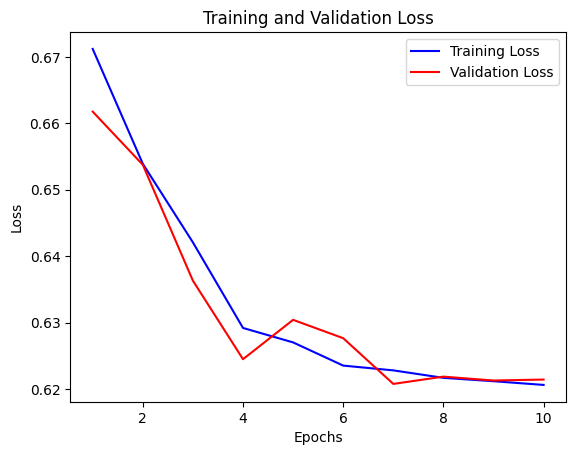

In [ ]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
y_test_pred = model.predict(X_test) > 0.5

print(classification_report(y_test, y_test_pred))
print("\n\n")

print('Roc_auc score')
print(roc_auc_score(y_test, y_test_pred))
print('\n')


print('Confusion matrix')
print(confusion_matrix(y_test, y_test_pred))

156/156 [==============================] - 15s 90ms/step
              precision    recall  f1-score   support

           0       0.67      0.62      0.65      2513
           1       0.64      0.69      0.66      2452

    accuracy                           0.65      4965
   macro avg       0.65      0.65      0.65      4965
weighted avg       0.65      0.65      0.65      4965




Roc_auc score
0.6539632572937202


Confusion matrix
[[1564  949]
 [ 771 1681]]
